## set up notebook

In [1]:
#!pwd

In [2]:
#full_ectopic

In [3]:
#ls /cluster/majf_lab/mtinti/RNAseq/experiments/obado/static/wcar.png

In [7]:
#reload when modified
%load_ext autoreload
%autoreload 2
#activate r magic
%load_ext rpy2.ipython
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc
from io import StringIO
from itertools import islice
from Bio import SeqIO
import utilities as UT
random.seed(1976)
np.random.seed(1976)

In [9]:
import multiprocessing
multiprocessing.cpu_count()

24

# Data Anaylsis

In [10]:
from tqdm.auto import tqdm
import os
replace_list = eval(open('vars_1_tb927_v68_paired.txt').read())
list_df = [n['experiment'] for n in replace_list]
list_path = [n+'/res1/'+n+'/counts.txt' for n in list_df]
list_path += [n+'/res2/'+n+'/counts.txt' for n in list_df]
list_path += [n+'/res3/'+n+'/counts.txt' for n in list_df]
#list_path += [n+'/res2/'+n+'/counts.txt' for n in list_df]
#list_path += [n+'/res3/'+n+'/counts.txt' for n in list_df]
#list_path += [n+'/res4/'+n+'/counts.txt' for n in list_df]
#list_path += [n+'/res6/'+n+'/counts.txt' for n in list_df]
for n in tqdm(list_path):
    if os.path.exists(n):
        pass
    else:
        print(n)

100%|██████████| 81/81 [00:00<00:00, 425.67it/s]


In [11]:
bed_file = open('CDS.bed','w')
for l in open('WT.34.A/res1/WT.34.A/counts.txt'):
    if l.startswith('#'):
        continue
    elif l.startswith('Geneid'):
        continue
    if len(l.split('\t')) == 7:
        if ';' in l:
            #print(l)
            gene_id = l.split('\t')[0].strip()
            chr_id = l.split('\t')[1].strip().split(';')[0]
            start = l.split('\t')[2].strip().split(';')[0]
            end = l.split('\t')[3].strip().split(';')[1]
        else:
            gene_id = l.split('\t')[0].strip()
            chr_id = l.split('\t')[1].strip()
            start = l.split('\t')[2].strip()
            end = l.split('\t')[3].strip()            
        bed_file.write('\t'.join([chr_id,start,end,gene_id+'\n']))
bed_file.close()

In [12]:
!head CDS.bed

5K5_v5.1	3	74	Tb05.5K5.10
5K5_v5.1	479	1756	Tb05.5K5.20
5K5_v5.1	5482	7392	Tb05.5K5.30
5K5_v5.1	8556	8963	Tb05.5K5.40
5K5_v5.1	9419	10717	Tb05.5K5.50
5K5_v5.1	11056	11712	Tb05.5K5.60
5K5_v5.1	12216	14114	Tb05.5K5.70
5K5_v5.1	15063	16118	Tb05.5K5.80
5K5_v5.1	16499	16771	Tb05.5K5.90
5K5_v5.1	17609	18118	Tb05.5K5.100


In [13]:
#!gtf2bed < genomes/BES/BES.gtf > BES.bed
bed_file = open('BES.bed','w')
for l in open('WT.34.A/res2/WT.34.A/counts.txt'):
    if l.startswith('#'):
        continue
    elif l.startswith('Geneid'):
        continue
    if len(l.split('\t')) == 7:
        if ';' in l:
            #print(l)
            gene_id = l.split('\t')[0].strip()
            chr_id = l.split('\t')[1].strip().split(';')[0]
            start = l.split('\t')[2].strip().split(';')[0]
            end = l.split('\t')[3].strip().split(';')[1]
        else:
            gene_id = l.split('\t')[0].strip()
            chr_id = l.split('\t')[1].strip()
            start = l.split('\t')[2].strip()
            end = l.split('\t')[3].strip()            
        bed_file.write('\t'.join([chr_id,start,end,gene_id+'\n']))
bed_file.close()

In [14]:
!head BES.bed

FM162566.1	1016	2041	gene-Tb427.BES40.1
FM162566.1	3584	4606	gene-Tb427.BES40.2
FM162566.1	5937	7142	gene-Tb427.BES40.3
FM162566.1	10737	12171	gene-Tb427.BES40.4
FM162566.1	13942	14865	gene-Tb427.BES40.5
FM162566.1	15044	15418	gene-Tb427.BES40.6
FM162566.1	16866	20672	gene-Tb427.BES40.7
FM162566.1	21730	22467	gene-Tb427.BES40.8
FM162566.1	25658	27688	gene-Tb427.BES40.9
FM162566.1	28645	29751	gene-Tb427.BES40.10


In [15]:
!mkdir -p InData/

In [16]:
#!bedtools nuc -fi genomes/tb927_v68/tb927_v68.fa -bed CDS.bed > InData/GC_content_927.txt

/usr/bin/sh: 1: bedtools: not found


In [17]:
#!bedtools nuc -fi genomes/BES/BES.fa -bed BES.bed > InData/GC_content_BES.txt

## Experiment SetUp

In [26]:
#!ls /app/host_mnt/Volumes/majf_lab/mtinti/Calvin/ESAG3_RNAi/F21FTSEUHT2083_TRYeqlrR/clean/InData/ 

In [27]:
def get_fasta_desc(fasta_desc):
    res = {}
    for n in fasta_desc.split(" | "):
        if '=' in n:
            key = n.split('=')[0].strip()
            value = n.split('=')[1].strip()
            res[key]=value
    return res

# from io import StringIO
def read_csv(filename, comment='#', sep='\t', ):
    lines = "".join([line for line in open(filename) 
                     if not line.startswith(comment)])
    return pd.read_csv(StringIO(lines), sep=sep)

df_list = []
for f in ['/app/host_mnt/Volumes/majf_lab/mtinti/Calvin/ESAG3_RNAi/F21FTSEUHT2083_TRYeqlrR/clean/InData/CD_Search/927_{}_hitdata.txt'.format(n) for n in range(0,4)]:
    temp = read_csv(f)
    temp['seq_id'] = [n.split(' ')[2][1:] for n in temp['Query']]
    temp['gene_id'] = [get_fasta_desc(n)['gene'] for n in temp['Query']]
    df_list.append(temp)
df_domains=pd.concat(df_list)
df_domains.tail()

,Query,Hit type,PSSM-ID,From,To,E-Value,Bitscore,Accession,Short name,Incomplete,Superfamily,seq_id,gene_id
2016,Q#2196 - >seq_11195 Tb11.1690:pseudogenic_tran...,non-specific,395732,88,403,2.926680e-04,43.1506,pfam00913,Trypan_glycop,-,-,seq_11195,Tb11.1690
2017,Q#2196 - >seq_11195 Tb11.1690:pseudogenic_tran...,superfamily,287612,475,514,8.069620e-03,36.2338,cl11264,Trypan_glycop_C superfamily,C,-,seq_11195,Tb11.1690
2018,Q#2197 - >seq_11196 Tb11.1700:pseudogenic_tran...,non-specific,395732,216,516,9.775360e-07,50.8546,pfam00913,Trypan_glycop,-,-,seq_11196,Tb11.1700
2019,Q#2202 - >seq_11201 Tb11.1800:pseudogenic_tran...,superfamily,302859,1,387,4.186380e-164,478.5540,cl19421,RHSP superfamily,C,-,seq_11201,Tb11.1800
2020,Q#2203 - >seq_11202 Tb11.1810.1-p1 | transcrip...,superfamily,302859,1,222,7.326060e-103,315.2300,cl19421,RHSP superfamily,N,-,seq_11202,Tb11.1810


In [28]:
domain_dict = {}
for temp_id in df_domains.gene_id.unique():
    temp = df_domains[df_domains['gene_id']==temp_id]
    domains = list(temp['Short name'].values) 
    domains = '; '.join(domains)
    domain_dict[temp_id]=domains
domain_dict[list(domain_dict.keys())[0]]

'VSG_B; Trypan_glycop_C'

In [17]:
!wget https://tritrypdb.org/common/downloads/release-68/TbruceiTREU927/gff/data/TriTrypDB-68_TbruceiTREU927.gff \
-O InData/TriTrypDB-68_TbruceiTREU927.gff

--2024-12-04 11:21:18--  https://tritrypdb.org/common/downloads/release-68/TbruceiTREU927/gff/data/TriTrypDB-68_TbruceiTREU927.gff
Resolving tritrypdb.org (tritrypdb.org)... 128.192.21.13
Connecting to tritrypdb.org (tritrypdb.org)|128.192.21.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9161873 (8.7M) [application/x-gff]
Saving to: ‘InData/TriTrypDB-68_TbruceiTREU927.gff’

InData/TriTrypDB-68 100%[===================>]   8.74M  2.26MB/s    in 3.9s    

2024-12-04 11:21:23 (2.26 MB/s) - ‘InData/TriTrypDB-68_TbruceiTREU927.gff’ saved [9161873/9161873]



In [29]:
#create a dictionary of gene to desc
#from the gff file
def make_desc(_GFF):
    gff =pd.read_csv( _GFF, sep='\t', header=None, comment='#')
    #print(gff)
    gff = gff[gff.iloc[:,2].str.contains('gene')]
    #print( gff[gff[gff.columns[-1]].str.contains('Tb427_020006200')] )
    #print(gff)
    desc = {}
    chr_dict = {}
    start_dict = {}
    sense_dict = {}
    for index,n in enumerate(gff.iloc[:,-1]):
        n=n.replace('%2C',' ')
        item_list = n.split(';')
        #print (item_list)
        temp_dict = {}
        for m in item_list:
            #print(m)
            temp_dict[m.split('=')[0].strip()]=m.split('=')[1].strip()
        #print(temp_dict['ID'])
        #print(temp_dict['description'])
        desc[temp_dict['ID']]=temp_dict.get('description','none')
        chr_dict[temp_dict['ID']]=gff.iloc[index][0]
        start_dict[temp_dict['ID']]=gff.iloc[index][3]
        sense_dict[temp_dict['ID']]=gff.iloc[index][6]
        
    return desc,chr_dict,start_dict,sense_dict

desc_dict_gff, chr_dict_gff, _, _ = make_desc('InData/TriTrypDB-68_TbruceiTREU927.gff')

In [37]:
#!pwd

In [38]:
#!ls -l /app/host_mnt/Volumes/majf_lab/mtinti

In [39]:
#create a dictionary of gene to desc
#from the gff file
def make_desc(_GFF):
    gff =pd.read_csv( _GFF, sep='\t', header=None, comment='#')
    
    gff = gff[gff.iloc[:,2]=='exon']
    
    #print( gff[gff[gff.columns[-1]].str.contains('Tb427_020006200')] )
    desc = {}
    chr_dict = {}
    start_dict = {}
    sense_dict = {}
    for index,n in enumerate(gff.iloc[:,-1]):
        #print(n)
        n=n.replace('%2C',' ')
        item_list = n.split(';')
        item_list = [n for n in item_list if len(n)>0]
        temp_dict = {}
        
        for m in item_list:
            
            temp_dict[m.strip().split(' ')[0].strip().replace('\"','')
                     ]=m.strip().split(' ')[1].strip().replace('\"','')
        #print(temp_dict)
        #print(temp_dict['description'])
        desc[temp_dict['gene_id']]=temp_dict.get('description', temp_dict['gene_id'])
        chr_dict[temp_dict['gene_id']]=gff.iloc[index][0]
        start_dict[temp_dict['gene_id']]=gff.iloc[index][3]
        sense_dict[temp_dict['gene_id']]=gff.iloc[index][6]
        
    return desc,chr_dict,start_dict,sense_dict

BES_desc_dict, BES_chr_dict, BES_start_dict, BES_sense_dict = make_desc('BES.gtf')
(list(BES_desc_dict.keys())[0],
 BES_desc_dict[list(BES_desc_dict.keys())[0]],
 BES_chr_dict[list(BES_desc_dict.keys())[0]],
 BES_start_dict[list(BES_desc_dict.keys())[0]],
BES_sense_dict[list(BES_desc_dict.keys())[0]],
)

('gene-Tb427.BES40.1', 'gene-Tb427.BES40.1', 'FM162566.1', np.int64(1016), '+')

In [40]:
#create a dictionary of gene to desc
#from the gff file
def make_desc(_GFF):
    gff =pd.read_csv( _GFF, sep='\t', header=None, comment='#')
    
    gff = gff[gff.iloc[:,2]=='exon']
    
    #print( gff[gff[gff.columns[-1]].str.contains('Tb427_020006200')] )
    desc = {}
    chr_dict = {}
    start_dict = {}
    sense_dict = {}
    for index,n in enumerate(gff.iloc[:,-1]):
        #print(n)
        n=n.replace('%2C',' ')
        item_list = n.split(';')
        item_list = [n for n in item_list if len(n)>0]
        temp_dict = {}
        
        for m in item_list:
            
            temp_dict[m.strip().split(' ')[0].strip().replace('\"','')
                     ]=m.strip().split(' ')[1].strip().replace('\"','')
        #print(temp_dict)
        #print(temp_dict['description'])
        desc[temp_dict['gene_id']]=temp_dict.get('description', temp_dict['gene_id'])
        chr_dict[temp_dict['gene_id']]=gff.iloc[index][0]
        start_dict[temp_dict['gene_id']]=gff.iloc[index][3]
        sense_dict[temp_dict['gene_id']]=gff.iloc[index][6]
        
    return desc,chr_dict,start_dict,sense_dict

desc_dict, chr_dict, start_dict, sense_dict = make_desc('tb927_v68.gtf')
(list(desc_dict.keys())[0],
 desc_dict[list(desc_dict.keys())[0]],
 chr_dict[list(desc_dict.keys())[0]],
 start_dict[list(desc_dict.keys())[0]],
sense_dict[list(desc_dict.keys())[0]],
)

('Tb05.5K5.10', 'Tb05.5K5.10', '5K5_v5.1', np.int64(3), '-')

In [41]:
chr_dict.update(chr_dict_gff)
desc_dict.update(desc_dict_gff)

In [42]:
#chr_dict.update(vsg_douglas_chr_dict)
#desc_dict.update(vsg_douglas_desc_dict)
#start_dict.update(vsg_douglas_start_dict)
#sense_dict.update(vsg_douglas_sense_dict)

In [43]:
bes_dict = {}
for l in open('../../Gustavo/F24A430000881_TRYrphyR/InData/bes_dict.csv'):
    key=l.split(',')[0]
    value=l.split(',')[1].strip()
    bes_dict[key]=value
print(bes_dict['gene-Tb427.BES29.1'])

BES29.ESAG10


In [44]:
bes_dict = {}
for l in open('../../Gustavo/F24A430000881_TRYrphyR/InData/bes_dict.csv'):
    key=l.split(',')[0]
    value=l.split(',')[1].strip()
    bes_dict[key]=value
print(bes_dict['gene-Tb427.BES29.1'])

BES29.ESAG10


In [45]:
#desc_dict['gene-Tb427.BES29.1']

In [46]:
vsg_dict = {}
for l in open('../../Gustavo/F24A430000881_TRYrphyR/InData/vsg_dic.txt'):
    if len(l) > 1:
        key='gene_'+l.split(' ')[0].replace('>','').strip()
        value=key+'_'+l.split(' ')[1].strip()
        vsg_dict[key]=value
print(vsg_dict['gene_Tb427VSG-476'])

gene_Tb427VSG-476_MC


In [47]:
vsg_dict = {}
for l in open('../../Gustavo/F24A430000881_TRYrphyR/InData/vsg_dic.txt'):
    if len(l) > 1:
        key='gene_'+l.split(' ')[0].replace('>','').strip()
        value=key+'_'+l.split(' ')[1].strip()
        vsg_dict[key]=value
print(vsg_dict['gene_Tb427VSG-476'])

gene_Tb427VSG-476_MC


In [48]:
desc_dict.update(vsg_dict)

In [49]:
desc_dict['Tb927.10.10850']

'Protein argonaute-1'

In [50]:
replace_list = eval(open('vars_2_BES_paired.txt').read())
list_df = [n['experiment'] for n in replace_list]

list_df = [n+'/res2/'+n+'/counts.txt' for n in list_df]
list_df =[pd.read_csv(n,index_col=[0],comment='#',sep='\t') for n in list_df]
df = list_df[0].copy()
for temp_df in tqdm(list_df[1:]):
    df = df.join(temp_df.iloc[:,-1])
df.head(10)
df.columns = [n.split('/')[3] if '/tmp/' in n else n for n in df.columns]
#df=df.drop('gene_BSD_MARKER')
df.head()

100%|██████████| 26/26 [00:00<00:00, 859.88it/s]


,Chr,Start,End,Strand,Length,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,...,ago1A.40.C,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C
Geneid,,,,,,,,,,,,,,,,,,,,,
gene-Tb427.BES40.1,FM162566.1,1016,2041,+,1026,0,0,0,0,0,...,828,1866,2222,1801,779,872,754,772,690,640
gene-Tb427.BES40.2,FM162566.1,3584,4606,+,1023,36520,39367,44458,40939,35690,...,96502,61173,61884,46792,29577,34135,34034,116464,113824,106595
gene-Tb427.BES40.3,FM162566.1,5937,7142,+,1206,24630,25592,30273,30389,27314,...,60970,34703,38813,30597,19078,19483,21017,76630,68740,70849
gene-Tb427.BES40.4,FM162566.1,10737,12171,+,1435,7700,7663,7331,7926,7101,...,8012,8612,7778,7155,5299,7489,6574,9004,9577,10164
gene-Tb427.BES40.5,FM162566.1,13942,14865,+,924,7283,8099,7964,9317,7830,...,15727,10930,10727,8485,6987,7944,8227,19242,20219,19551


In [51]:
df_bes = df.copy()

In [52]:
replace_list = eval(open('vars_1_tb927_v68_paired.txt').read())
list_df = [n['experiment'] for n in replace_list]

list_df = [n+'/res1/'+n+'/counts.txt' for n in list_df]
list_df =[pd.read_csv(n,index_col=[0],comment='#',sep='\t') for n in list_df]
df = list_df[0].copy()
for temp_df in tqdm(list_df[1:]):
    df = df.join(temp_df.iloc[:,-1])
df.head(10)
df.columns = [n.split('/')[3] if '/tmp/' in n else n for n in df.columns]
#df=df.drop('gene_BSD_MARKER')
df.head()

100%|██████████| 26/26 [00:00<00:00, 497.18it/s]


,Chr,Start,End,Strand,Length,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,...,ago1A.40.C,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C
Geneid,,,,,,,,,,,,,,,,,,,,,
Tb05.5K5.10,5K5_v5.1,3,74,-,72,12,9,6,13,9,...,18,11,9,15,13,12,11,20,16,8
Tb05.5K5.20,5K5_v5.1,479,1756,-,1278,587,598,568,756,740,...,742,577,521,508,516,641,585,714,765,780
Tb05.5K5.30,5K5_v5.1,5482,7392,-,1911,637,772,617,799,711,...,957,806,581,749,610,968,879,582,897,818
Tb05.5K5.40,5K5_v5.1,8556,8963,-,408,1810,1581,1735,1904,2104,...,1759,1705,1842,1694,1629,1804,1745,2091,2007,1794
Tb05.5K5.50,5K5_v5.1,9419,10717,-,1299,746,719,709,807,743,...,710,703,666,571,581,717,718,755,721,701


In [53]:
df = pd.concat([df,df_bes])

In [54]:
#df.loc['gene_Tb427VSG-464']

In [55]:
df=df.drop('gene_GFP-BLA_MARKER')

In [56]:
df['Chr']=[n.split(';')[0] for n in df['Chr']]

In [57]:
markers = df[ [n.endswith('_MARKER') for  n in df['Chr'] ]]
markers.head()

,Chr,Start,End,Strand,Length,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,...,ago1A.40.C,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C
Geneid,,,,,,,,,,,,,,,,,,,,,
gene_T7_RNAP_MARKER,T7_RNAP_MARKER,1,2687,+,2687,0,0,0,0,0,...,1356,1600,1593,1517,1546,1819,1659,1557,1397,1358
gene_BLE_MARKER,BLE_MARKER,1,350,+,350,0,0,0,0,0,...,361,374,484,426,177,143,157,268,241,200
gene_BLA_MARKER,BLA_MARKER,1,397,+,397,0,0,0,0,0,...,758,707,946,756,766,764,786,983,802,885
gene_HYG_MARKER,HYG_MARKER,1,1025,+,1025,0,0,0,0,0,...,430,1010,1210,953,431,449,376,389,350,334
gene_NEO_MARKER,NEO_MARKER,1,956,+,956,323,550,351,457,255,...,17333,23147,23945,21927,21668,24859,23784,18474,17618,17914


In [58]:
mito = df[  df['Chr'].isin(['M94286.1']) ]
mito.head()

,Chr,Start,End,Strand,Length,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,...,ago1A.40.C,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C
Geneid,,,,,,,,,,,,,,,,,,,,,
gene-12S rRNA,M94286.1,1364,2512,+,1149,6,4,8,8,4,...,4,3,5,4,10,9,7,8,12,8
gene-9S rRNA,M94286.1,2542,3152,+,611,14,6,17,16,6,...,12,13,15,10,13,12,16,28,14,21
gene-ND7,M94286.1,4066,4767,+,702,4164,3537,3886,4412,3788,...,9023,5357,8617,6341,9245,6085,8532,16975,11097,11936
gene-COIII,M94286.1,4768,5206,+,439,5377,5547,5149,5502,4199,...,8730,4637,8786,5999,8749,4493,8539,10682,7666,8268
gene-Cyb,M94286.1,5275,6354,+,1080,725,452,475,414,378,...,241,426,903,516,544,408,473,520,323,301


In [59]:
vsgs = df[ [n.startswith('Tb427VSG') for  n in df['Chr'] ]] 
vsgs.head()

,Chr,Start,End,Strand,Length,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,...,ago1A.40.C,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C
Geneid,,,,,,,,,,,,,,,,,,,,,
gene_Tb427VSG-2,Tb427VSG-2,1,1199,+,1199,1975956,2113964,2114160,2234232,2289804,...,1409076,1877210,1896346,1717094,1877321,1975057,2022264,1307561,1326983,1427839
gene_Tb427VSG-11,Tb427VSG-11,1,1199,+,1199,954,1292,1212,1453,1188,...,322,800,779,702,773,967,872,229,217,277
gene_Tb427VSG-3,Tb427VSG-3,1,1199,+,1199,416,487,510,553,460,...,90,190,186,171,146,192,227,33,45,59
gene_Tb427VSG-6,Tb427VSG-6,1,1199,+,1199,847,1143,1034,1318,1019,...,1602,1140,1111,1031,963,1118,1169,1589,1372,1501
gene_Tb427VSG-8,Tb427VSG-8,1,1199,+,1199,1144,1657,1637,1928,1479,...,5139,1956,1984,1781,1710,2063,1941,2716,2492,2879


In [60]:
esags = df[ [n.startswith('FM') for  n in df['Chr'] ]] 

In [61]:
filter_esag = ~pd.Series([n.startswith('FM162566') for  n in esags['Chr'] ],index=esags.index.values)
filter_esag

gene-Tb427.BES40.1     False
gene-Tb427.BES40.2     False
gene-Tb427.BES40.3     False
gene-Tb427.BES40.4     False
gene-Tb427.BES40.5     False
                       ...  
gene-Tb427.BES51.8      True
gene-Tb427.BES51.9      True
gene-Tb427.BES51.10     True
gene-Tb427.BES51.11     True
gene-Tb427.BES51.12     True
Length: 167, dtype: bool

In [62]:
esags_minus2 = esags[filter_esag ]

In [63]:
#these are the VSGs in BES, we removed as they are 
#replaced by the truncated VSGs version
mask_ids = ['gene-Tb427.BES40.22', 
            'gene-Tb427.BES129.14', 
            'gene-Tb427.BES15.12', 
            'gene-Tb427.BES28.15', 
            'gene-Tb427.BES98.12', 
            'gene-Tb427.BES65.13', 
            'gene-Tb427.BES64.2', 
            'gene-Tb427.BES134.6', 
            'gene-Tb427.BES122.11', 
            'gene-Tb427.BES29.9', 
            'gene-Tb427.BES56.13', 
            'gene-Tb427.BES10.10', 
            'gene-Tb427.BES126.15', 
            'gene-Tb427.BES51.12']

In [64]:
print(esags.shape)
esags=esags.drop(mask_ids)
print(esags.shape)

(167, 32)
(153, 32)


In [65]:
print(df.shape)
df=df.drop(mask_ids)
print(df.shape)

(10145, 32)
(10131, 32)


In [46]:
!mkdir -p Figures_927

In [66]:
df.loc['Tb927.10.10850']=['Tb927_10_v5.1', '2635529', '2638240', '-', 2712, 3418, 3683, 3518,
       3110, 3276, 3201, 3862, 3895, 3922, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [67]:
markers.loc['AGO1']=df.loc['Tb927.10.10850']
markers.loc['VSG-2']=df.loc['gene_Tb427VSG-2']

#markers.loc['gene_Tb427VSG-2']=df.loc['gene_Tb427VSG-2']
#markers.loc['gene_H4_KO_neo_cassette']=df.loc['gene_H4_KO_neo_cassette']

In [68]:
markers.shape
markers

,Chr,Start,End,Strand,Length,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,...,ago1A.40.C,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C
Geneid,,,,,,,,,,,,,,,,,,,,,
gene_T7_RNAP_MARKER,T7_RNAP_MARKER,1,2687,+,2687,0,0,0,0,0,...,1356,1600,1593,1517,1546,1819,1659,1557,1397,1358
gene_BLE_MARKER,BLE_MARKER,1,350,+,350,0,0,0,0,0,...,361,374,484,426,177,143,157,268,241,200
gene_BLA_MARKER,BLA_MARKER,1,397,+,397,0,0,0,0,0,...,758,707,946,756,766,764,786,983,802,885
gene_HYG_MARKER,HYG_MARKER,1,1025,+,1025,0,0,0,0,0,...,430,1010,1210,953,431,449,376,389,350,334
gene_NEO_MARKER,NEO_MARKER,1,956,+,956,323,550,351,457,255,...,17333,23147,23945,21927,21668,24859,23784,18474,17618,17914
gene_PAC_MARKER,PAC_MARKER,1,599,+,599,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gene_GFP_MARKER,GFP_MARKER,1,715,+,715,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AGO1,Tb927_10_v5.1,2635529,2638240,-,2712,3418,3683,3518,3110,3276,...,1,1,1,1,1,1,1,1,1,1
VSG-2,Tb427VSG-2,1,1199,+,1199,1975956,2113964,2114160,2234232,2289804,...,1409076,1877210,1896346,1717094,1877321,1975057,2022264,1307561,1326983,1427839


In [69]:
#np.log10(out_table).loc['gene_pT7sgRNA_H4B'].plot(kind='bar')

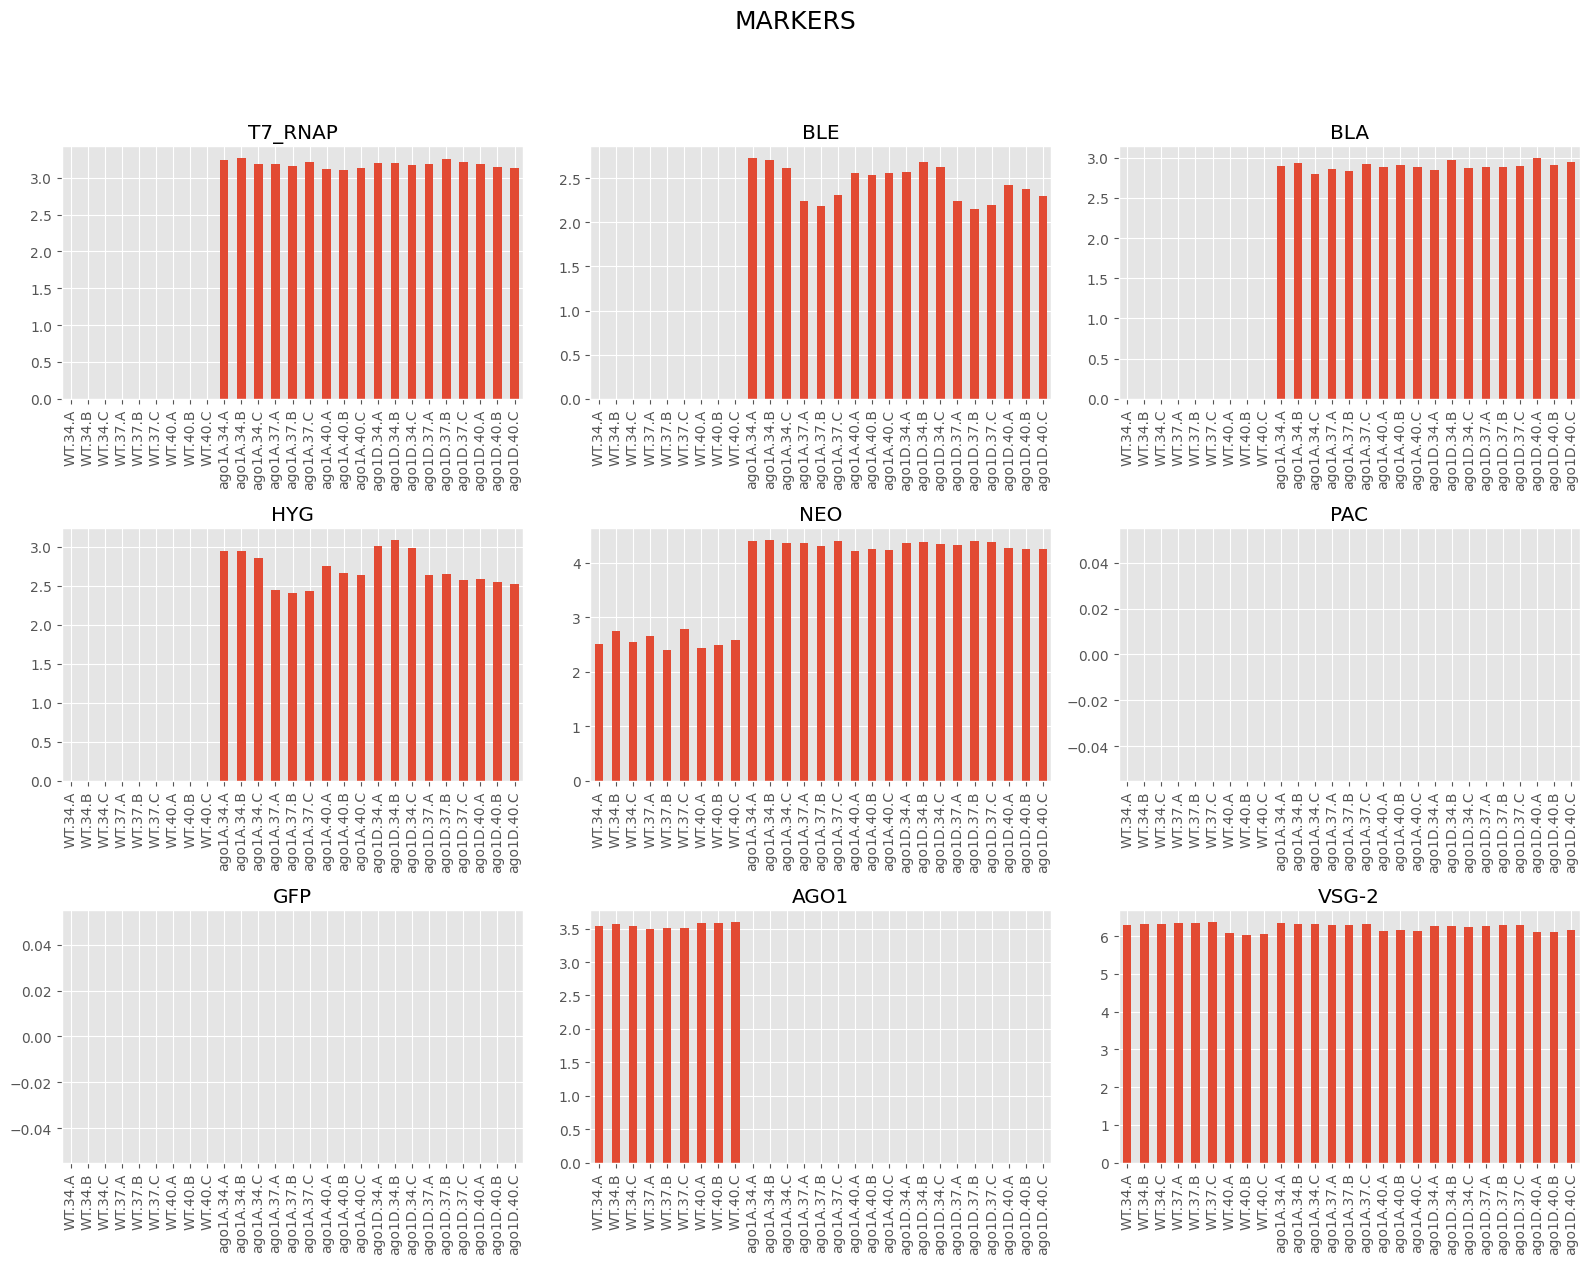

In [70]:
fig,axes = plt.subplots(figsize=(16,12),ncols=3,nrows=3)
axes=axes.flatten()
for i,marker in enumerate(markers.index.values):
    plot_title = marker.replace('gene_','').replace('_MARKER','')
    
    tmp_df = markers.loc[marker][5:].astype(int)
    tmp_df=tmp_df
    np.log10(tmp_df).plot(kind='bar',ax=axes[i])
    axes[i].set_title(plot_title)
plt.suptitle('MARKERS',y=1.05,fontsize=18)
plt.tight_layout()
plt.savefig('Figures_927/MARKERS_log_counts.png')
plt.show()

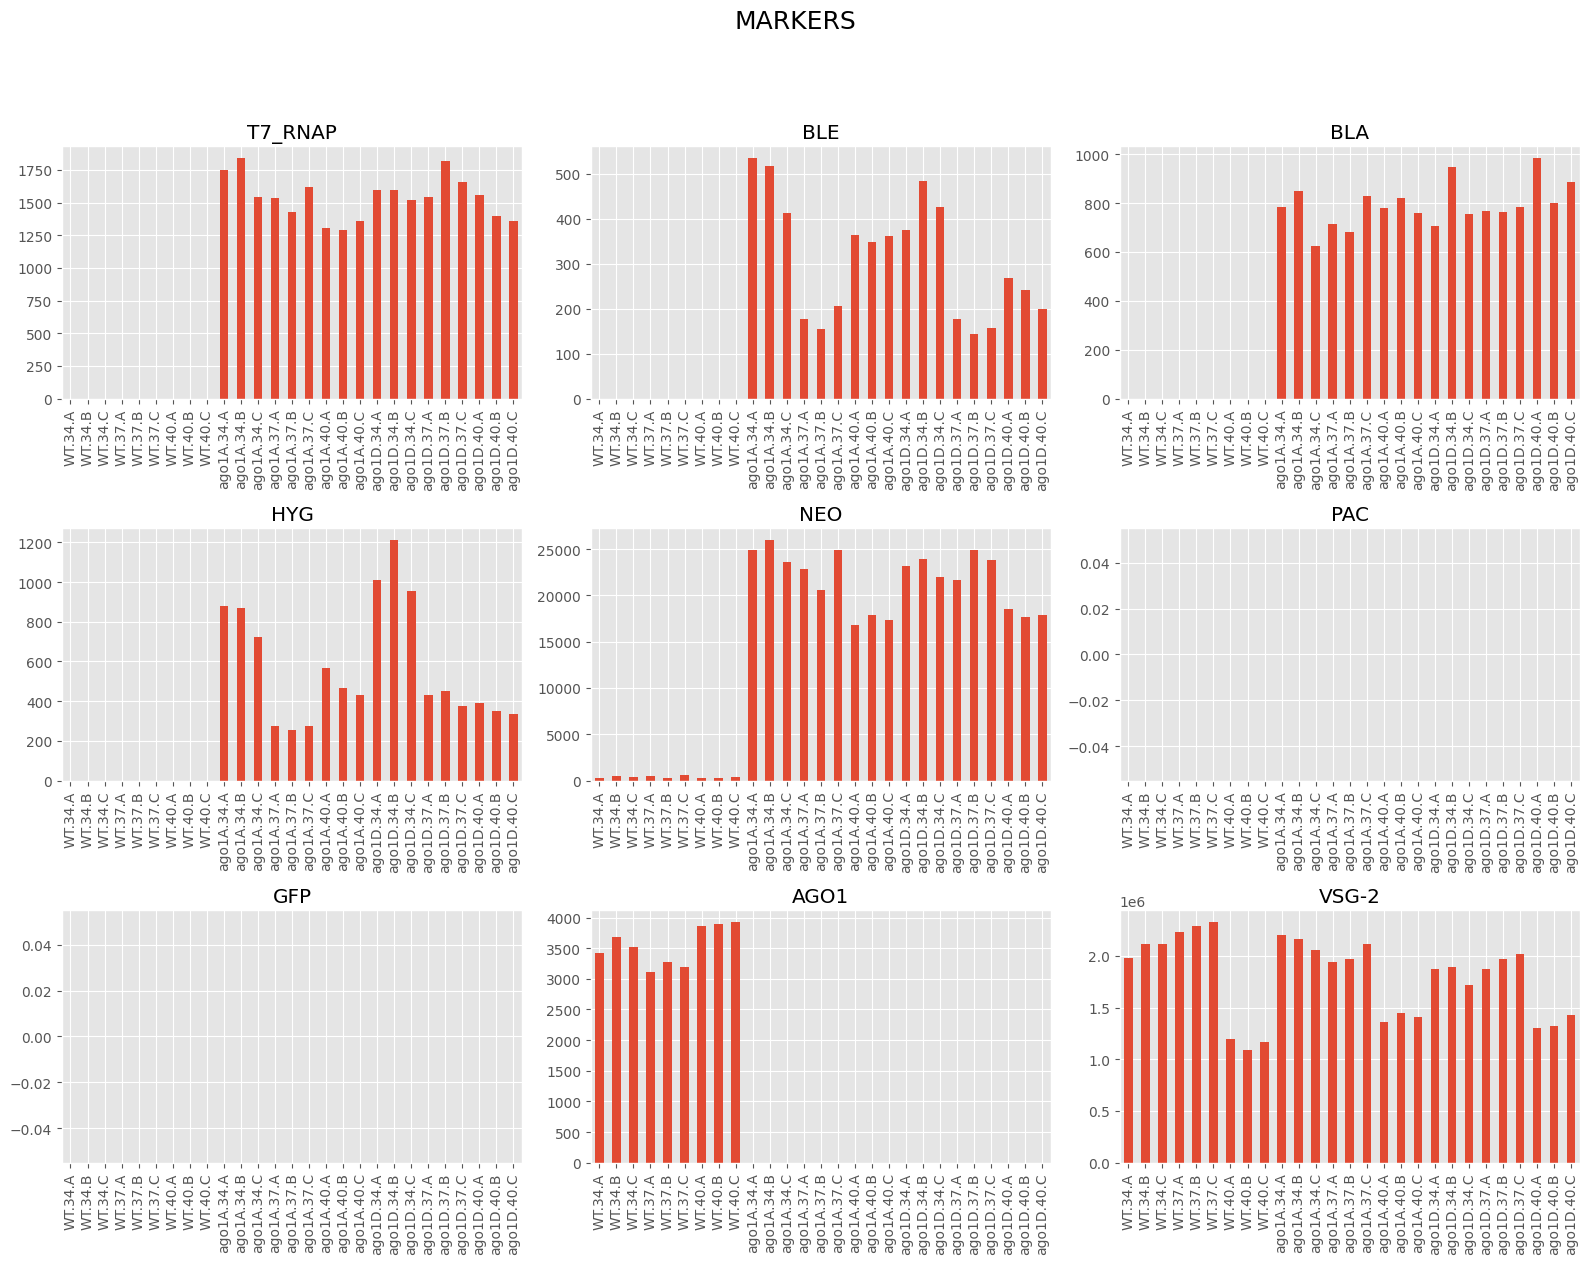

In [71]:
fig,axes = plt.subplots(figsize=(16,12),ncols=3,nrows=3)
axes=axes.flatten()
for i,marker in enumerate(markers.index.values):
    plot_title = marker.replace('gene_','').replace('_MARKER','')
    
    tmp_df = markers.loc[marker][5:].astype(int)
    tmp_df=tmp_df
    tmp_df.plot(kind='bar',ax=axes[i])
    axes[i].set_title(plot_title)
plt.suptitle('MARKERS',y=1.05,fontsize=18)
plt.tight_layout()
#plt.savefig('Figures_927/MARKERS_counts.png')
plt.show()

In [72]:
len('''
ATGGCCAAGGGCAAGAAGTCCGGCGAGGCCAAGGGCTCCCAGAAGCGGCAGAAGAAGGTG
CTGCGCGAGAACGTGCGCGGCATCACGCGCGGCTCGATCCGCCGCCTGGCGCGGCGCGGC
GGCGTGAAGCGCATCTCGGGCGTGATCTACGACGAGGTCCGCGGCGTGCTGAAGTCGTTC
GTGGAGGGCGTGGTGCGCGACGCGACGGCGTACACGGAGTACTCGCGCAAGAAGACGGTG
ACGGCGGTGGACGTGGTGAACGCGCTGCGCAAGCGCGGCAAGATCCTGTACGGCTACGCG
TAA''')

309

In [73]:
df.head()

,Chr,Start,End,Strand,Length,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,...,ago1A.40.C,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C
Geneid,,,,,,,,,,,,,,,,,,,,,
Tb05.5K5.10,5K5_v5.1,3,74,-,72,12,9,6,13,9,...,18,11,9,15,13,12,11,20,16,8
Tb05.5K5.20,5K5_v5.1,479,1756,-,1278,587,598,568,756,740,...,742,577,521,508,516,641,585,714,765,780
Tb05.5K5.30,5K5_v5.1,5482,7392,-,1911,637,772,617,799,711,...,957,806,581,749,610,968,879,582,897,818
Tb05.5K5.40,5K5_v5.1,8556,8963,-,408,1810,1581,1735,1904,2104,...,1759,1705,1842,1694,1629,1804,1745,2091,2007,1794
Tb05.5K5.50,5K5_v5.1,9419,10717,-,1299,746,719,709,807,743,...,710,703,666,571,581,717,718,755,721,701


In [74]:
indata=df.copy()

In [75]:
print(indata.shape)
indata=indata.iloc[:,5:].dropna()
print(indata.shape)
#indata.loc['KS17gene_1749a']
#indata['desc']=[desc_dict.get(n,'none') for n in indata.index.values]
#indata.to_csv('indata.csv')
#indata.head()
#indata.loc['mainVSG-427-2']

#indata = indata.replace(1,np.nan).dropna(axis=1, how='all')
#print(indata.shape)
#indata.describe()

(10131, 32)
(10131, 27)


In [76]:
indata.head()

,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,WT.37.C,WT.40.A,WT.40.B,WT.40.C,ago1A.34.A,...,ago1A.40.C,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C
Geneid,,,,,,,,,,,,,,,,,,,,,
Tb05.5K5.10,12,9,6,13,9,13,7,15,10,14,...,18,11,9,15,13,12,11,20,16,8
Tb05.5K5.20,587,598,568,756,740,748,884,796,873,552,...,742,577,521,508,516,641,585,714,765,780
Tb05.5K5.30,637,772,617,799,711,789,975,948,936,834,...,957,806,581,749,610,968,879,582,897,818
Tb05.5K5.40,1810,1581,1735,1904,2104,1872,1918,1779,1843,1539,...,1759,1705,1842,1694,1629,1804,1745,2091,2007,1794
Tb05.5K5.50,746,719,709,807,743,745,750,806,829,644,...,710,703,666,571,581,717,718,755,721,701


In [77]:
#indata.loc['gene_Tb427VSG-464']

In [78]:
#indata.loc['gene_Tb427VSG-2'],indata.loc['gene-Tb427.BES126.1'],indata.loc['gene_Tb427VSG-516']
##print(vsg_dict['gene_Tb427VSG-464'],vsg_dict['gene_Tb427VSG-516'])

## QC - Missing Data Viz

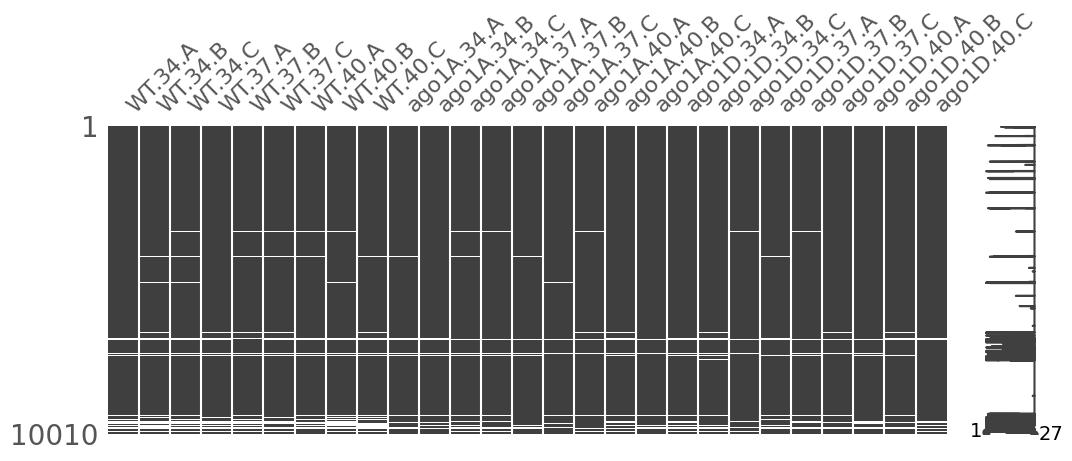

In [79]:
msno.matrix(indata.replace(0,np.nan).dropna(how='all'),figsize=(12, 4))
plt.savefig('Figures_927/missing.png')
plt.show()

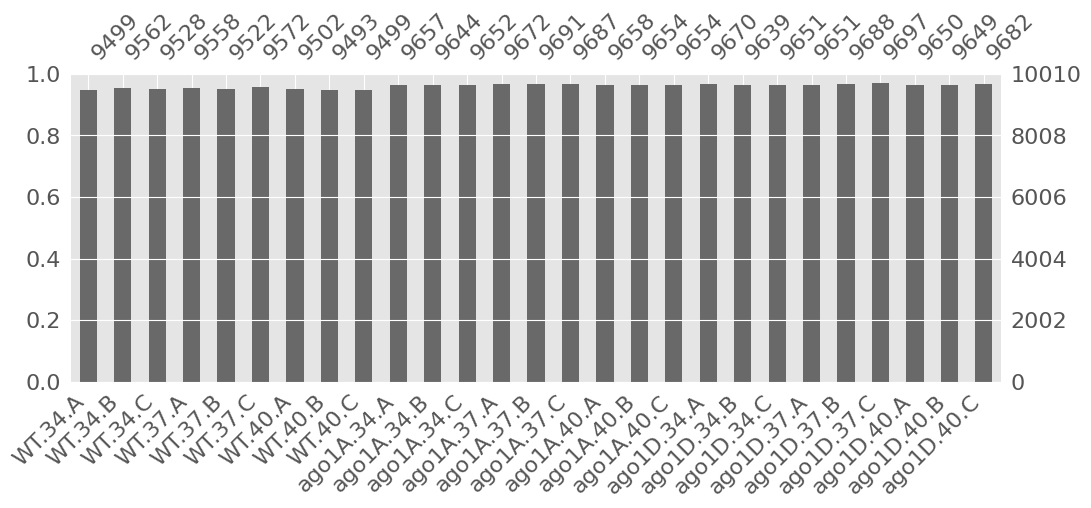

In [80]:
msno.bar(indata.replace(0,np.nan).dropna(how='all'),figsize=(12, 4))
plt.savefig('Figures_927/missing_bar.png')
plt.show()

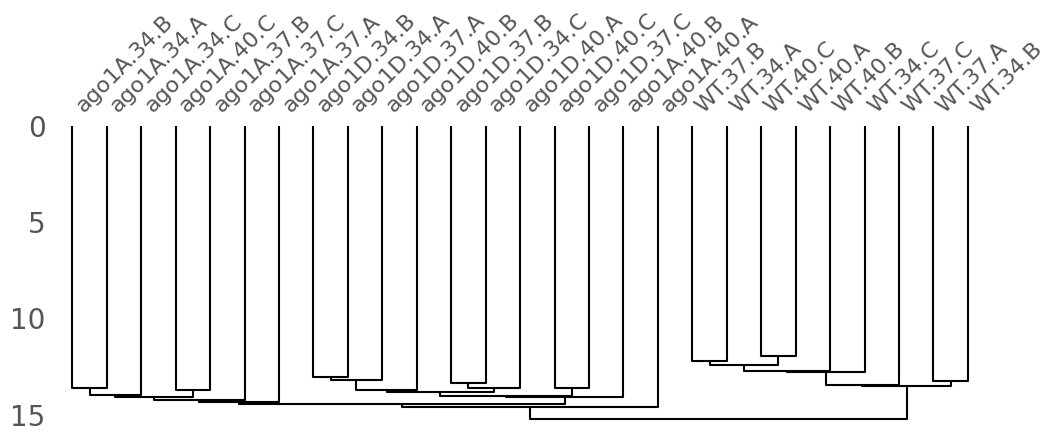

In [81]:
msno.dendrogram(indata.replace(0,np.nan).dropna(how='all'),figsize=(12, 4))
plt.savefig('Figures_927/missing_dendogram.png')
plt.show()

In [82]:
#!mkdir -p Figures_927

In [84]:
UT.make_mds??

Signature:
UT.make_mds(
    in_df,
    palette,
    ax,
    top=500,
    color_dictionary=False,
    do_adjust_text=True,
)
Docstring: <no docstring>
Source:   
def make_mds(in_df, palette, ax, top=500, 
             color_dictionary=False,do_adjust_text=True):
    cols = in_df.columns
    
    
    
    sorted_mean = in_df.mean(axis=1).sort_values()
    select = sorted_mean.tail(top)
    #print(top)
    in_df = in_df.loc[select.index.values]
    
    pca = MDS(n_components=2, metric=True)
    temp_df = pd.DataFrame(pca.fit_transform(in_df.T),
                                 index=cols, 
                           columns =['pc_1', 'pc_2'] )
    
    temp_df['color']=palette
    
    temp_df.plot(kind='scatter',x='pc_1', y='pc_2', s=50, c=temp_df['color'], ax=ax)
    #print(temp_df.head())
    for color in temp_df['color'].unique():
        c_data = temp_df[temp_df['color']==color].iloc[0]
        ax.scatter(x=c_data.pc_1, y=c_data.pc_2, c=color, label=color,s=50)
        ax.legend(ti

## QC - MSD

In [90]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
def make_mds(in_df, palette, ax, top=500, 
             color_dictionary=False,do_adjust_text=True):
    cols = in_df.columns
    
    
    
    sorted_mean = in_df.mean(axis=1).sort_values()
    select = sorted_mean.tail(top)
    #print(top)
    in_df = in_df.loc[select.index.values]
    
    pca = MDS(n_components=2, metric=True)
    temp_df = pd.DataFrame(pca.fit_transform(in_df.T),
                                 index=cols, 
                           columns =['pc_1', 'pc_2'] )
    
    temp_df['color']=palette
    
    temp_df.plot(kind='scatter',x='pc_1', y='pc_2', s=50, c=temp_df['color'], ax=ax)
    #print(temp_df.head())
    for color in temp_df['color'].unique():
        c_data = temp_df[temp_df['color']==color].iloc[0]
        ax.scatter(x=c_data.pc_1, y=c_data.pc_2, c=color, label=color,s=50)
        ax.legend(title='Groups',loc='center left', bbox_to_anchor=(1, 0.5))
      
    
    #.plot(kind='scatter',x='pc_1', y='pc_2', s=50, c=temp_df['color'], ax=ax)
    
    
    
    
    texts = [ax.text(temp_df.iloc[i]['pc_1'], 
                       temp_df.iloc[i]['pc_2'],
                       cols[i])
                       for i in range(temp_df.shape[0])]
    if do_adjust_text:
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'),ax=ax)
    ax.set_title('MDS',size=14)
    ax.set_xlabel('DIM_1',size=12)
    ax.set_ylabel('DIM_2',size=12)
    ax.yaxis.label.set_size(12)
    ax.xaxis.label.set_size(12)
    if color_dictionary:
        print(color_dictionary)
        handles, labels = ax.get_legend_handles_labels()
        labels = [ color_dictionary[l] for l in labels]
        ax.legend(handles=handles, labels=labels, 
        title='Groups',loc='center left', bbox_to_anchor=(1, 0.9))
    return ax

{'r': 'WT', 'b': 'other'}


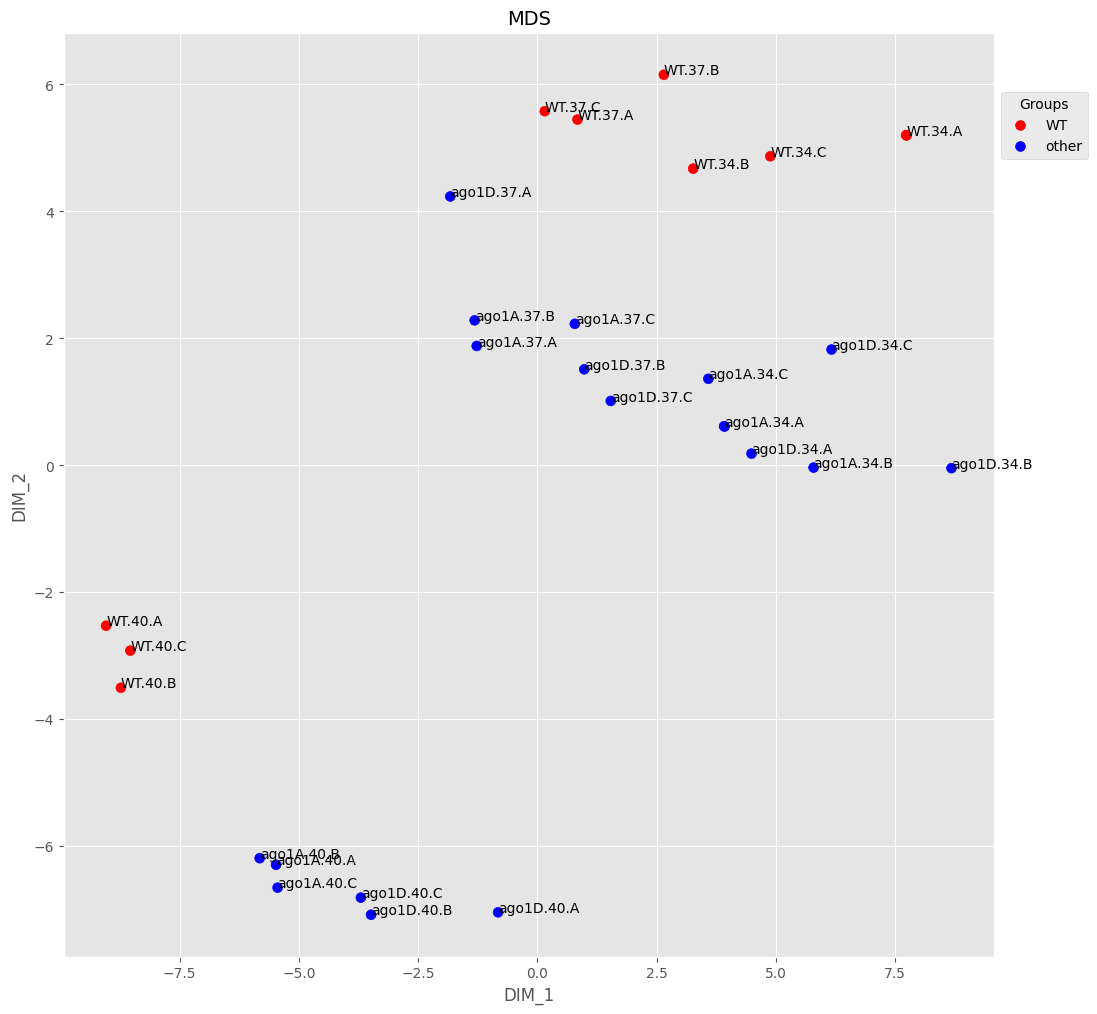

In [92]:
plt.style.use('ggplot')
palette = ['r' if 'WT' in n else 'b' for n in indata.columns]
fig,ax = plt.subplots(figsize=(12,12), ncols=1, nrows=1)
make_mds(np.log2(indata),palette,ax,color_dictionary={'r':'WT','b':'other',},do_adjust_text=False)
#plt.savefig('Figures_927/MDS.png')
plt.show()

In [97]:
def make_pca(in_df, palette, ax, top=500, 
             color_dictionary=False, do_adjust_text=False):
    
    cols = in_df.columns
    
    
    sorted_mean = in_df.mean(axis=1).sort_values()
    select = sorted_mean.tail(top)
    #print(top)
    in_df = in_df.loc[select.index.values]
    
    pca = PCA(n_components=2)
    pca.fit(in_df)
    
    temp_df = pd.DataFrame()
    temp_df['pc_1']=pca.components_[0]
    temp_df['pc_2']=pca.components_[1]
    temp_df.index = cols
    print(pca.explained_variance_ratio_)
    temp_df['color']=palette
    #fig,ax=plt.subplots(figsize=(12,6))
    temp_df.plot(kind='scatter',x='pc_1', y='pc_2',s=30, c=temp_df['color'], ax=ax)
    #print(temp_df.index.values)

    for color in temp_df['color'].unique():
        c_data = temp_df[temp_df['color']==color].iloc[0]
        ax.scatter(x=c_data.pc_1, y=c_data.pc_2, c=color, label=color,s=30)
        ax.legend(title='Groups',loc='center left', bbox_to_anchor=(1, 0.5))
    
    
    
    texts = [ax.text(temp_df.iloc[i]['pc_1'], 
                       temp_df.iloc[i]['pc_2'],
                       cols[i])
                       for i in range(temp_df.shape[0])]
    
    if do_adjust_text:
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'),ax=ax)
    ax.set_title('PCA', size=14)
    ax.set_xlabel('PC1_{:.3f}'.format(pca.explained_variance_ratio_[0]),size=12)
    ax.set_ylabel('PC2_{:.3f}'.format(pca.explained_variance_ratio_[1]),size=12)
    ax.yaxis.label.set_size(12)
    ax.xaxis.label.set_size(12)
    
    if color_dictionary:
        print(color_dictionary)
        handles, labels = ax.get_legend_handles_labels()
        labels = [ color_dictionary[l] for l in labels]
        ax.legend(handles=handles, labels=labels, 
        title='Groups',loc='center left', bbox_to_anchor=(1, 0.9))    
    return ax,temp_df

[0.90284811 0.06947367]
{'r': 'WT', 'b': 'other'}


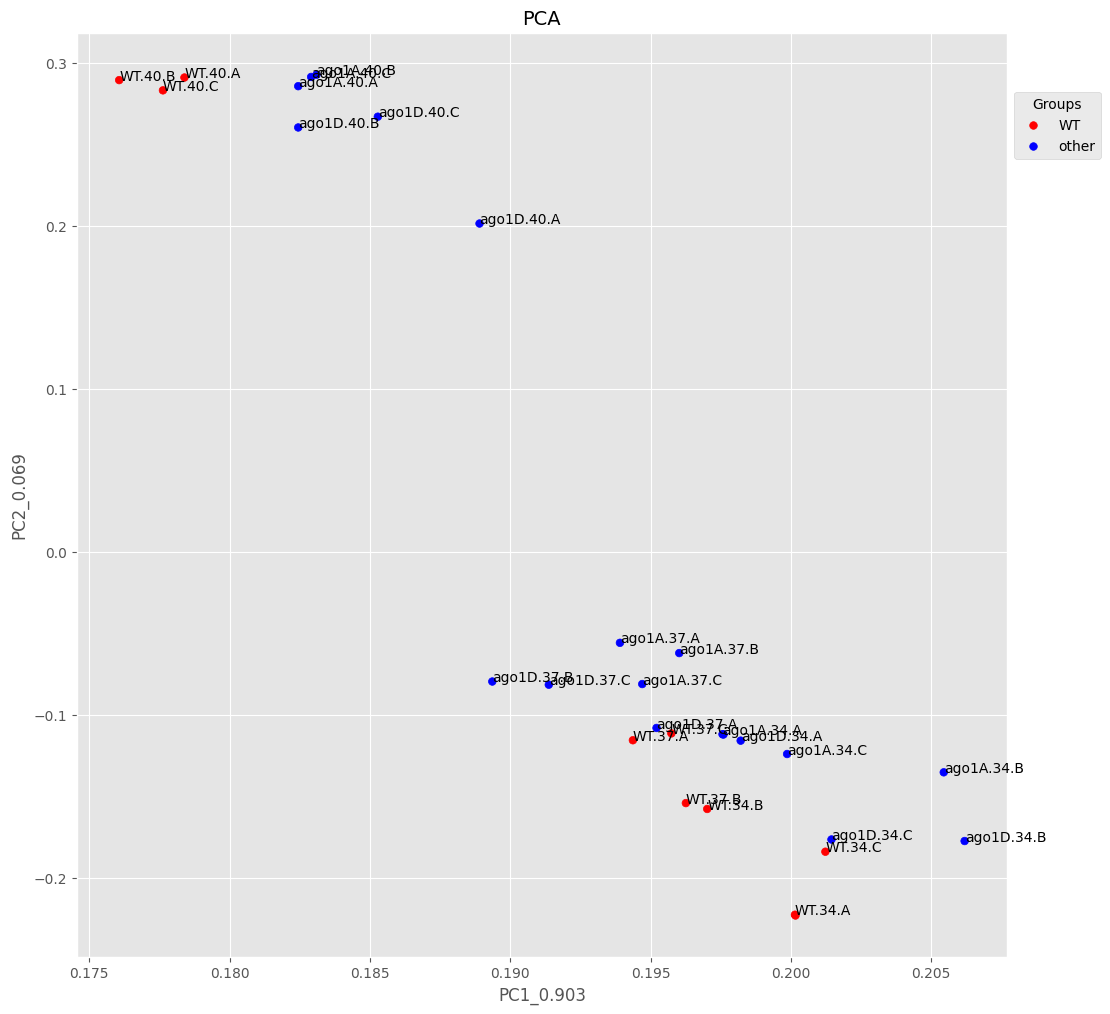

In [99]:
plt.style.use('ggplot')
fig,ax = plt.subplots(figsize=(12,12), ncols=1, nrows=1)
ax,temp_df = make_pca(np.log2(indata),palette,ax,color_dictionary={'r':'WT','b':'other',})
#plt.savefig('Figures_927/PCA.png')
temp_df.to_csv('pca_data.csv')

In [66]:
def get_gene_ids(n):
    res = {}
    temp = n.split(';')
    temp =[n.strip() for n in temp if len(n)>2]
    temp = temp[:2]
    #print(temp)
    for f in temp:
        key = f.split(' ')[0]
        value = f.split(' ')[1]
        key=key.replace('\"','').replace('\'','').strip()
        value=value.replace('\"','').replace('\'','').strip()
        res[key]=value
    return res['gene_id']

In [67]:
#gc_content.head()

In [68]:
res_gc = []
for file_name in ['InData/GC_content_927.txt',
                  'InData/GC_content_BES.txt'
                 ]:
    gc_content = pd.read_csv(file_name,sep='\t')
    #gc_content = gc_content[gc_content['8_usercol']=='exon']
    gc_content['gene_id'] = gc_content['4_usercol']#[get_gene_ids(n) for n in gc_content['4_usercol']]
    gc_content = gc_content.drop_duplicates('gene_id')
    gc_content.set_index('gene_id',inplace=True)
    gc_content=gc_content[['13_seq_len','6_pct_gc']]
    gc_content.columns = ['length', 'gccontent']
    res_gc.append(gc_content)
res_gc = pd.concat(res_gc)
res_gc.head()

,length,gccontent
gene_id,,
Tb05.5K5.10,71,0.394366
Tb05.5K5.20,1277,0.462020
Tb05.5K5.30,1910,0.481152
Tb05.5K5.40,407,0.503685
Tb05.5K5.50,1298,0.483821


In [69]:
res_gc.loc['gene_Tb427VSG-2'],res_gc.loc['gene-Tb427.BES126.1'],res_gc.loc['gene_Tb427VSG-516']

(length       1198.000000
 gccontent       0.523372
 Name: gene_Tb427VSG-2, dtype: float64, length       2060.000000
 gccontent       0.481553
 Name: gene-Tb427.BES126.1, dtype: float64, length       1198.000000
 gccontent       0.505008
 Name: gene_Tb427VSG-516, dtype: float64)

In [70]:
#res_gc.loc['gene-12S'],res_gc.loc['gene-12S']

In [71]:
indata.head()

,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,WT.37.C,WT.40.A,WT.40.B,WT.40.C,ago1A.34.A,...,ago1A.40.C,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C
Geneid,,,,,,,,,,,,,,,,,,,,,
Tb05.5K5.10,12,9,6,13,9,13,7,15,10,14,...,18,11,9,15,13,12,11,20,16,8
Tb05.5K5.20,587,598,568,756,740,748,884,796,873,552,...,742,577,521,508,516,641,585,714,765,780
Tb05.5K5.30,637,772,617,799,711,789,975,948,936,834,...,957,806,581,749,610,968,879,582,897,818
Tb05.5K5.40,1810,1581,1735,1904,2104,1872,1918,1779,1843,1539,...,1759,1705,1842,1694,1629,1804,1745,2091,2007,1794
Tb05.5K5.50,746,719,709,807,743,745,750,806,829,644,...,710,703,666,571,581,717,718,755,721,701


In [72]:
indata2 = indata.join(res_gc,how='inner')
indata2.shape,indata.shape

((10131, 29), (10131, 27))

In [73]:
#indata2.head(50)

In [74]:
#indata2.loc['gene-Tb427.BES126.1']

In [75]:
gc_content = indata2[['length', 'gccontent']]
gc_content

,length,gccontent
Tb05.5K5.10,71,0.394366
Tb05.5K5.20,1277,0.462020
Tb05.5K5.30,1910,0.481152
Tb05.5K5.40,407,0.503685
Tb05.5K5.50,1298,0.483821
...,...,...
gene-Tb427.BES51.7,1892,0.435518
gene-Tb427.BES51.8,1104,0.379529
gene-Tb427.BES51.9,1388,0.410663
gene-Tb427.BES51.10,698,0.434097


In [76]:
indata2.drop(['length', 'gccontent'],axis=1,inplace=True) 
indata.shape,indata2.shape,gc_content.shape

((10131, 27), (10131, 27), (10131, 2))

In [77]:
indata = indata2.copy()

In [78]:
indata

,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,WT.37.C,WT.40.A,WT.40.B,WT.40.C,ago1A.34.A,...,ago1A.40.C,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C
Tb05.5K5.10,12,9,6,13,9,13,7,15,10,14,...,18,11,9,15,13,12,11,20,16,8
Tb05.5K5.20,587,598,568,756,740,748,884,796,873,552,...,742,577,521,508,516,641,585,714,765,780
Tb05.5K5.30,637,772,617,799,711,789,975,948,936,834,...,957,806,581,749,610,968,879,582,897,818
Tb05.5K5.40,1810,1581,1735,1904,2104,1872,1918,1779,1843,1539,...,1759,1705,1842,1694,1629,1804,1745,2091,2007,1794
Tb05.5K5.50,746,719,709,807,743,745,750,806,829,644,...,710,703,666,571,581,717,718,755,721,701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-Tb427.BES51.7,133,134,89,120,105,138,227,217,223,110,...,235,188,153,122,143,134,182,284,296,329
gene-Tb427.BES51.8,1101,1052,934,960,831,942,813,1124,1030,1350,...,1109,1748,1709,1287,1227,1484,1595,1218,1447,1354
gene-Tb427.BES51.9,3171,3311,3305,3197,3206,3086,4394,4776,4691,3411,...,4471,3432,3424,3017,3282,3736,3571,4855,4819,4689
gene-Tb427.BES51.10,386,452,397,468,357,391,506,616,638,432,...,650,553,486,416,451,472,546,774,803,817


In [79]:
#indata.columns = [n.replace('.','_') for n in indata.columns]

In [80]:
#indata=indata.fillna(0)

### edgeR to filter low counts

In [81]:
%%R -i indata
options(warn=-1)
library("limma") 
library("edgeR")
head(indata)

            WT.34.A WT.34.B WT.34.C WT.37.A WT.37.B WT.37.C WT.40.A WT.40.B
Tb05.5K5.10      12       9       6      13       9      13       7      15
Tb05.5K5.20     587     598     568     756     740     748     884     796
Tb05.5K5.30     637     772     617     799     711     789     975     948
Tb05.5K5.40    1810    1581    1735    1904    2104    1872    1918    1779
Tb05.5K5.50     746     719     709     807     743     745     750     806
Tb05.5K5.60     879     789     868     883     939     895     961     948
            WT.40.C ago1A.34.A ago1A.34.B ago1A.34.C ago1A.37.A ago1A.37.B
Tb05.5K5.10      10         14          8          8         10         14
Tb05.5K5.20     873        552        535        597        540        595
Tb05.5K5.30     936        834        457        781        775        718
Tb05.5K5.40    1843       1539       1494       1573       1707       1585
Tb05.5K5.50     829        644        700        677        631        601
Tb05.5K5.60     92

In [82]:
indata.columns

Index(['WT.34.A', 'WT.34.B', 'WT.34.C', 'WT.37.A', 'WT.37.B', 'WT.37.C',
       'WT.40.A', 'WT.40.B', 'WT.40.C', 'ago1A.34.A', 'ago1A.34.B',
       'ago1A.34.C', 'ago1A.37.A', 'ago1A.37.B', 'ago1A.37.C', 'ago1A.40.A',
       'ago1A.40.B', 'ago1A.40.C', 'ago1D.34.A', 'ago1D.34.B', 'ago1D.34.C',
       'ago1D.37.A', 'ago1D.37.B', 'ago1D.37.C', 'ago1D.40.A', 'ago1D.40.B',
       'ago1D.40.C'],
      dtype='object')

In [83]:
%%R
group <- factor(c(
    'WT34','WT34','WT34',
    'WT37','WT37','WT37',
    'WT40','WT40','WT40',
    'MUT34','MUT34','MUT34',
    'MUT37','MUT37','MUT37',
    'MUT40','MUT40','MUT40',
    'MUT34','MUT34','MUT34',
    'MUT37','MUT37','MUT37',
    'MUT40','MUT40','MUT40'
))

y <- DGEList(counts=indata,group=group)
keep <- filterByExpr(y, min.count = 10, min.total.count = 30)
y <- y[keep,,keep.lib.sizes=FALSE]
counts = y$counts
genes = row.names(y)

In [84]:
%R -o counts,genes
indata = pd.DataFrame(counts,index=genes,columns=indata.columns)
indata.shape

(9396, 27)

In [85]:
#indata.loc['Tb927.5.2600']

In [86]:
indata=indata.join(gc_content,how='inner')
indata.shape

(9396, 29)

### GC / length content

In [87]:
gc_content = indata[['length', 'gccontent']]
indata.drop(['length', 'gccontent'],axis=1,inplace=True)
print(indata.shape,gc_content.shape)
indata.head()

(9396, 27) (9396, 2)


,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,WT.37.C,WT.40.A,WT.40.B,WT.40.C,ago1A.34.A,...,ago1A.40.C,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C
Tb05.5K5.10,12,9,6,13,9,13,7,15,10,14,...,18,11,9,15,13,12,11,20,16,8
Tb05.5K5.20,587,598,568,756,740,748,884,796,873,552,...,742,577,521,508,516,641,585,714,765,780
Tb05.5K5.30,637,772,617,799,711,789,975,948,936,834,...,957,806,581,749,610,968,879,582,897,818
Tb05.5K5.40,1810,1581,1735,1904,2104,1872,1918,1779,1843,1539,...,1759,1705,1842,1694,1629,1804,1745,2091,2007,1794
Tb05.5K5.50,746,719,709,807,743,745,750,806,829,644,...,710,703,666,571,581,717,718,755,721,701


In [88]:
#indata.loc['Tb927.1.5340']

### size factors

In [89]:
sizeFactors=indata.sum()
sizeFactors = sizeFactors.values
sizeFactors

array([26571297, 25801234, 25929760, 26292462, 26779155, 26310519,
       25986371, 25185164, 25680881, 26095806, 26023991, 25589829,
       23825616, 23583520, 25990575, 24621419, 24898129, 25078789,
       25420715, 25228702, 23371224, 22587877, 25681788, 25364983,
       24450734, 24754903, 25205289])

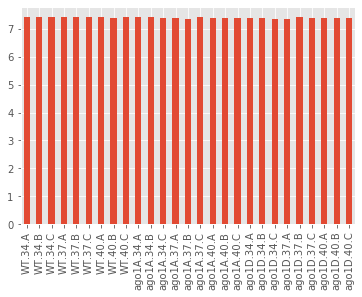

In [90]:
np.log10(pd.Series(sizeFactors,index=indata.columns)).plot(kind='bar')

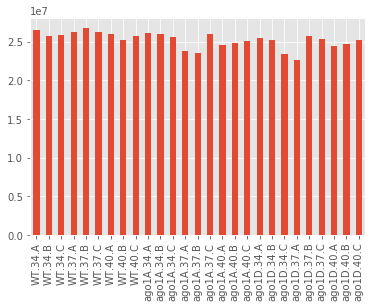

In [91]:
pd.Series(sizeFactors,index=indata.columns).plot(kind='bar')

### Bias Correction

In [92]:
%%R -i gc_content,indata,sizeFactors
library(cqn)
library(scales)

R[write to console]: Loading required package: mclust

R[write to console]: Package 'mclust' version 5.4.6
Type 'citation("mclust")' for citing this R package in publications.

R[write to console]: Loading required package: nor1mix

R[write to console]: Loading required package: preprocessCore

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: quantreg

R[write to console]: Loading required package: SparseM

R[write to console]: 
Attaching package: ‘SparseM’


R[write to console]: The following object is masked from ‘package:base’:

    backsolve




In [93]:
%%R
stopifnot(all(rownames(indata) == rownames(gc_content)))
cqn.subset <- cqn(indata, lengths = gc_content$length,
                  x = gc_content$gccontent, sizeFactors = sizeFactors,
                  verbose = TRUE)

RQ fit ...........................
SQN .


In [94]:
#%R cqn.subset

### Viz Bias

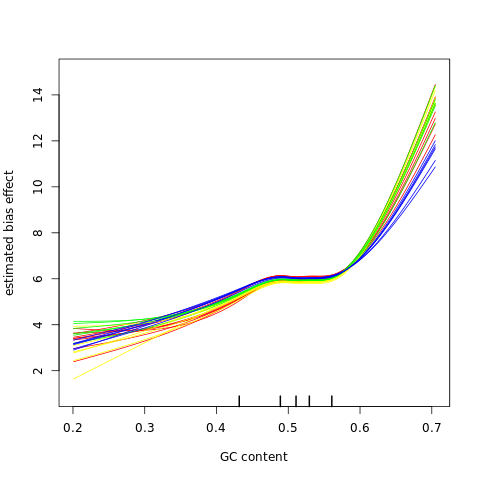

In [95]:
%%R
cqnplot <- function(x, n = 1, col = "grey60", ylab="estimated bias effect", 
                    xlab = "", type = "l", lty = 1, ...) {
    if(class(x) != "cqn")
        stop("'x' needs to be of class 'cqn'")
    if(n == 1) {
        func <- x$func1
        grid <- x$grid1
        knots <- x$knots1
    }
    if(n == 2) {
        if(is.null(x$func2))
            stop("argument 'x' does not appear to have two smooth functions (component 'func2' is NULL)")
        func <- x$func2
        grid <- x$grid2
        knots <- x$knots2
    }
    
    
    #par(mar=c(5.1, 4.1, 4.1, 8.1), xpd=TRUE)
    matplot(replicate(ncol(func), grid), func, ylab = ylab, xlab = xlab, type = type,
            col = col, lty = lty, ...)
    
    legend("bottomleft", legend = colnames(x$counts), inset=c(1,0),
           title="Samples", lty = lty, col = col)
    rug(knots, lwd = 2)
    invisible(x)
    
}


library(repr)
#options(repr.plot.width = 10, repr.plot.height = 0.75)
# Change plot size to 4 x 3
#options(repr.plot.width=4, repr.plot.height=3)


colors <-  c('red',  'red',  'red',  
             'red', 'red', 'red', 
             'red', 'red', 'red', 
             'yellow', 'yellow',  'yellow',
             'green', 'green', 'green', 
             'blue', 'blue',  'blue',             
             'yellow', 'yellow',  'yellow',
             'green', 'green', 'green', 
             'blue', 'blue',  'blue')

lty =c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
       1, 1, 1, 1, 1, 1, 1)

#png("Figures/Figure_12.png")
#par(mfrow=c(1,2))
cqnplot(cqn.subset, col=colors,
        n = 1, xlab = "GC content", lty = lty,
        ylim = c(1, 15), 
        
       )
#dev.off()

#ggsave('plot.png', width=8.27, height= 11.69) #A4 size in inches
#dev.off()

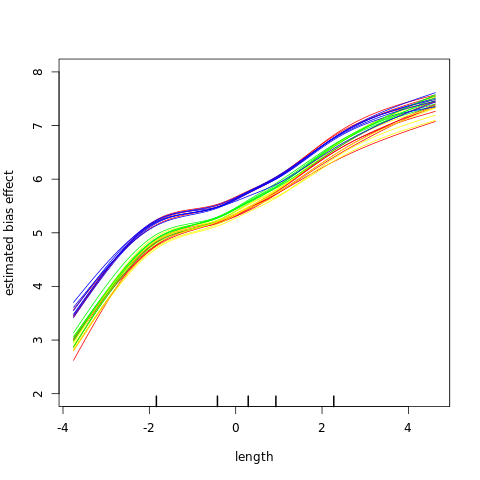

In [96]:
%%R
library(repr)
#options(repr.plot.width = 12, repr.plot.height = 0.75)
# Change plot size to 4 x 3
#options(repr.plot.width=8, repr.plot.height=3)


colors <-  c('red',  'red',  'red',  
             'red', 'red', 'red', 
             'red', 'red', 'red', 
             'yellow', 'yellow',  'yellow',
             'green', 'green', 'green', 
             'blue', 'blue',  'blue',             
             'yellow', 'yellow',  'yellow',
             'green', 'green', 'green', 
             'blue', 'blue',  'blue')

lty =c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
       1, 1, 1, 1, 1, 1, 1)


#par(mfrow=c(1,2))
#png("Figures/Figure_13.png")
cqnplot(cqn.subset, col=colors,
        n = 2, xlab = "length", lty = lty,
        ylim = c(2,8), 
    
       )
#dev.off()

### Bias Correction

In [97]:
%%R
RPKM.cqn <- cqn.subset$y + cqn.subset$offset
out_table <- RPKM.cqn
head(out_table)

             WT.34.A  WT.34.B  WT.34.C  WT.37.A  WT.37.B  WT.37.C  WT.40.A
Tb05.5K5.10 4.044135 3.289589 3.441043 4.048076 3.623082 3.913520 2.629976
Tb05.5K5.20 5.607595 5.636729 5.633988 5.919362 5.913571 5.924424 5.862776
Tb05.5K5.30 5.279778 5.529283 5.304946 5.515538 5.386165 5.518215 5.571489
Tb05.5K5.40 7.326935 7.258184 7.336305 7.434766 7.542868 7.438076 7.319204
Tb05.5K5.50 5.697899 5.667760 5.704295 5.755916 5.650685 5.664055 5.418219
Tb05.5K5.60 6.166210 6.132167 6.257477 6.159574 6.207001 6.198314 6.130081
             WT.40.B  WT.40.C ago1A.34.A ago1A.34.B ago1A.34.C ago1A.37.A
Tb05.5K5.10 3.570592 3.070837   3.863888   3.548132   2.794783   3.249175
Tb05.5K5.20 5.742673 5.840101   5.506581   5.594449   5.595682   5.455785
Tb05.5K5.30 5.613951 5.531745   5.636127   4.966954   5.571489   5.543614
Tb05.5K5.40 7.199229 7.246949   7.301725   7.214443   7.328425   7.512117
Tb05.5K5.50 5.590803 5.589669   5.536147   5.723287   5.582363   5.494705
Tb05.5K5.60 6.163897 6.101145  

In [98]:
#out_table

In [99]:
%R -o out_table
out_table = pd.DataFrame(out_table,index=indata.index.values,columns=indata.columns)
out_table.head()

,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,WT.37.C,WT.40.A,WT.40.B,WT.40.C,ago1A.34.A,...,ago1A.40.C,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C
Tb05.5K5.10,4.044135,3.289589,3.441043,4.048076,3.623082,3.913520,2.629976,3.570592,3.070837,3.863888,...,3.435164,3.495575,3.391075,3.994059,3.733666,3.548132,3.283070,3.868461,3.324671,2.123886
Tb05.5K5.20,5.607595,5.636729,5.633988,5.919362,5.913571,5.924424,5.862776,5.742673,5.840101,5.506581,...,5.681934,5.550605,5.535418,5.540896,5.514063,5.568486,5.491240,5.772552,5.717006,5.755916
Tb05.5K5.30,5.279778,5.529283,5.304946,5.515538,5.386165,5.518215,5.571489,5.613951,5.531745,5.636127,...,5.644432,5.636729,5.336239,5.671538,5.348065,5.696849,5.639643,5.189857,5.580585,5.487351
Tb05.5K5.40,7.326935,7.258184,7.336305,7.434766,7.542868,7.438076,7.319204,7.199229,7.246949,7.301725,...,7.310221,7.413589,7.433001,7.476566,7.448193,7.454857,7.405303,7.471204,7.474317,7.308386
Tb05.5K5.50,5.697899,5.667760,5.704295,5.755916,5.650685,5.664055,5.418219,5.590803,5.589669,5.536147,...,5.437610,5.664618,5.676199,5.489943,5.488002,5.523889,5.583688,5.678811,5.499963,5.469899


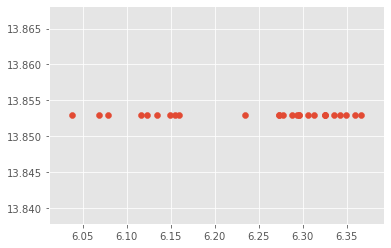

In [100]:
plt.scatter(np.log10(indata.loc['gene_Tb427VSG-2']), out_table.loc['gene_Tb427VSG-2'])

In [101]:
#indata.loc['gene_Tb427VSG-2']

In [102]:
#indata.loc['KS17gene_7016a']

In [103]:
out_table.columns

Index(['WT.34.A', 'WT.34.B', 'WT.34.C', 'WT.37.A', 'WT.37.B', 'WT.37.C',
       'WT.40.A', 'WT.40.B', 'WT.40.C', 'ago1A.34.A', 'ago1A.34.B',
       'ago1A.34.C', 'ago1A.37.A', 'ago1A.37.B', 'ago1A.37.C', 'ago1A.40.A',
       'ago1A.40.B', 'ago1A.40.C', 'ago1D.34.A', 'ago1D.34.B', 'ago1D.34.C',
       'ago1D.37.A', 'ago1D.37.B', 'ago1D.37.C', 'ago1D.40.A', 'ago1D.40.B',
       'ago1D.40.C'],
      dtype='object')

### Visualise Normalized Counts

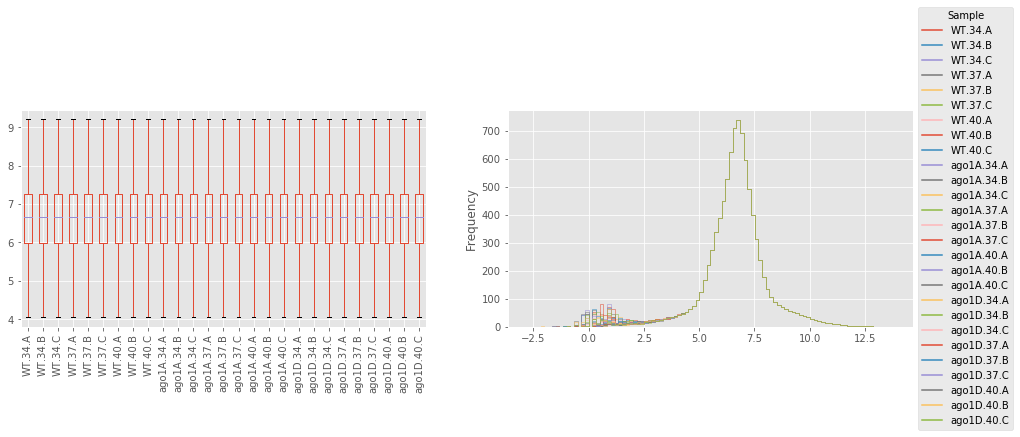

(9396, 27)


In [104]:
fig,axes=plt.subplots(figsize=(16,4),ncols=2)
ax = axes[0]
out_table.plot(kind='box',ax=ax,rot=90,showfliers=False)

ax = axes[1]
out_table.replace(-np.inf,-1.5).plot(kind='hist',
                                            histtype='step',
                                            bins=100,ax=ax)
UT.hist_legend(ax,'Sample')
#ax.set_xticklabels(out_df.columns, rotation=90, )
plt.savefig('Figures_927/norm.png')
plt.show()
print(out_table.shape)

In [105]:
out_table.to_csv('rpkm_927.csv')

In [106]:
markers

,Chr,Start,End,Strand,Length,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,...,ago1A.40.C,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C
Geneid,,,,,,,,,,,,,,,,,,,,,
gene_T7_RNAP_MARKER,T7_RNAP_MARKER,1,2687,+,2687,0,0,0,0,0,...,1356,1600,1593,1517,1546,1819,1659,1557,1397,1358
gene_BLE_MARKER,BLE_MARKER,1,350,+,350,0,0,0,0,0,...,361,374,484,426,177,143,157,268,241,200
gene_BLA_MARKER,BLA_MARKER,1,397,+,397,0,0,0,0,0,...,758,707,946,756,766,764,786,983,802,885
gene_HYG_MARKER,HYG_MARKER,1,1025,+,1025,0,0,0,0,0,...,430,1010,1210,953,431,449,376,389,350,334
gene_NEO_MARKER,NEO_MARKER,1,956,+,956,323,550,351,457,255,...,17333,23147,23945,21927,21668,24859,23784,18474,17618,17914
gene_PAC_MARKER,PAC_MARKER,1,599,+,599,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gene_GFP_MARKER,GFP_MARKER,1,715,+,715,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AGO1,Tb927_10_v5.1,2635529,2638240,-,2712,3418,3683,3518,3110,3276,...,1,1,1,1,1,1,1,1,1,1
VSG-2,Tb427VSG-2,1,1199,+,1199,1975956,2113964,2114160,2234232,2289804,...,1409076,1877210,1896346,1717094,1877321,1975057,2022264,1307561,1326983,1427839


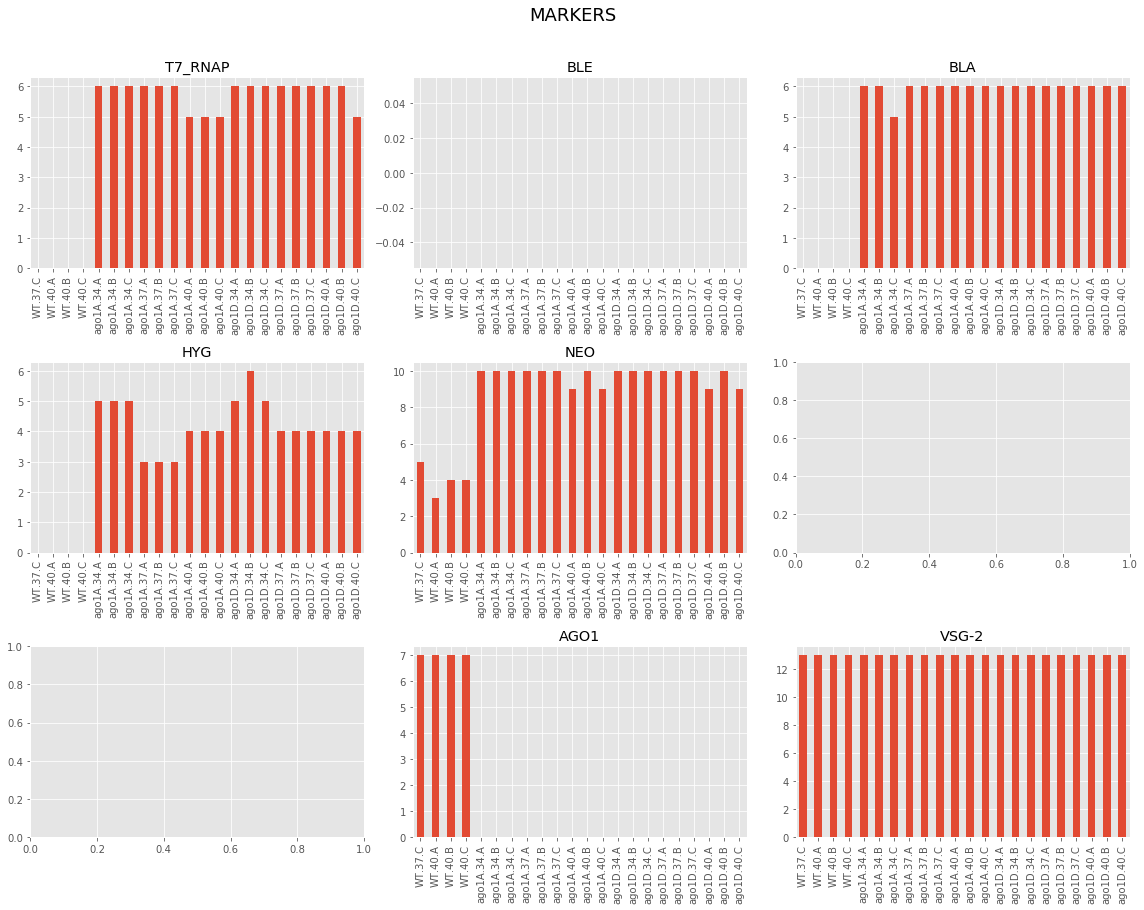

In [107]:
fig,axes = plt.subplots(figsize=(16,12),ncols=3,nrows=3)
axes=axes.flatten()
for i,marker in enumerate(markers.index.values):
    plot_title = marker.replace('gene_','').replace('_MARKER','')
    #markers.loc['AGO1']=df.loc['Tb927.10.10850']
    #markers.loc['VSG-2']=df.loc['gene_Tb427VSG-2']
    if marker == 'AGO1':
        marker = 'Tb927.10.10850'
    if marker == 'VSG-2':
        marker = 'gene_Tb427VSG-2'
    if marker in out_table.index.values:
        tmp_df = out_table.loc[marker][5:].astype(int)
        tmp_df=tmp_df
        tmp_df.plot(kind='bar',ax=axes[i])
        axes[i].set_title(plot_title)

plt.suptitle('MARKERS',y=1.05,fontsize=18)
plt.tight_layout()
plt.savefig('Figures_927/MARKERS_rpkm.png')
plt.show()

In [108]:
#out_table.loc['']

In [109]:
indata

,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,WT.37.C,WT.40.A,WT.40.B,WT.40.C,ago1A.34.A,...,ago1A.40.C,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C
Tb05.5K5.10,12,9,6,13,9,13,7,15,10,14,...,18,11,9,15,13,12,11,20,16,8
Tb05.5K5.20,587,598,568,756,740,748,884,796,873,552,...,742,577,521,508,516,641,585,714,765,780
Tb05.5K5.30,637,772,617,799,711,789,975,948,936,834,...,957,806,581,749,610,968,879,582,897,818
Tb05.5K5.40,1810,1581,1735,1904,2104,1872,1918,1779,1843,1539,...,1759,1705,1842,1694,1629,1804,1745,2091,2007,1794
Tb05.5K5.50,746,719,709,807,743,745,750,806,829,644,...,710,703,666,571,581,717,718,755,721,701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-Tb427.BES51.7,133,134,89,120,105,138,227,217,223,110,...,235,188,153,122,143,134,182,284,296,329
gene-Tb427.BES51.8,1101,1052,934,960,831,942,813,1124,1030,1350,...,1109,1748,1709,1287,1227,1484,1595,1218,1447,1354
gene-Tb427.BES51.9,3171,3311,3305,3197,3206,3086,4394,4776,4691,3411,...,4471,3432,3424,3017,3282,3736,3571,4855,4819,4689
gene-Tb427.BES51.10,386,452,397,468,357,391,506,616,638,432,...,650,553,486,416,451,472,546,774,803,817


## Diff Expression

In [110]:
!mkdir -p contrast_tables_927
!rm -r contrast_tables_927/*

In [111]:
%%R
#https://rstudio-pubs-static.s3.amazonaws.com/79395_b07ae39ce8124a5c873bd46d6075c137.html
library(edgeR)
# Make groups

# Define a function to automate the contrast and saving the results
automate_contrasts_and_save <- function(design_matrix, fit_obj, groups) {
  # Iterate over all pairs of groups
  for (i in 1:(length(groups) - 1)) {
    for (j in (i + 1):length(groups)) {
      # Perform contrast for both directions
      for (direction in c(1, -1)) {
        if (direction == 1) {
          contrast_expr <- paste("group", groups[i], "-group", groups[j], sep="")
          file_name <- paste0("contrast_tables_927/", groups[i], "_vs_", groups[j], ".txt")
        } else {
          contrast_expr <- paste("group", groups[j], "-group", groups[i], sep="")
          file_name <- paste0("contrast_tables_927/", groups[j], "_vs_", groups[i], ".txt")
        }
        
        # Generate the contrast matrix
        contrast_matrix <- makeContrasts(contrasts=contrast_expr, levels=design_matrix)
        
        # Perform the contrast test
        contrast <- glmQLFTest(fit_obj, contrast=contrast_matrix)
        result_table <- topTags(contrast, n=Inf, sort.by="none", adjust.method="BH")$table
        
        # Save the result as a text file
        write.table(result_table, file=file_name, sep="\t", quote=FALSE, row.names=TRUE)
      }
    }
  }
}


group <- factor(c(
    'WT34','WT34','WT34',
    'WT37','WT37','WT37',
    'WT40','WT40','WT40',
    'MUT34','MUT34','MUT34',
    'MUT37','MUT37','MUT37',
    'MUT40','MUT40','MUT40',
    'MUT34','MUT34','MUT34',
    'MUT37','MUT37','MUT37',
    'MUT40','MUT40','MUT40'
  
))


design_with_all <- model.matrix( ~0+group )

y <- DGEList(counts=indata, 
                  lib.size = sizeFactors,
                  group = group, 
                  )

y$offset <- cqn.subset$glm.offset
# Estimate dispersion
y <- estimateGLMCommonDisp( y, design_with_all )
y <- estimateGLMTrendedDisp( y, design_with_all )
y <- estimateGLMTagwiseDisp( y, design_with_all )
# Fit counts to model
fit_all <- glmQLFit( y, design_with_all )


groups <- c('WT34', 'WT37', 'WT40', 'MUT34',  'MUT37', 'MUT40')

# Call the function
automate_contrasts_and_save(design_with_all, fit_all, groups)



In [112]:
indata2 = indata.copy()
indata2['desc']=[desc_dict.get(n,n) for n in indata2.index.values]
indata2.to_csv('contrast_tables_927/indata.txt',sep='\t')

In [113]:
%%R
contrast <- glmQLFTest( fit_all, contrast=makeContrasts( groupMUT34-groupWT34, levels=design_with_all ) )
table1 <- topTags(contrast, n=Inf, sort.by = "none", adjust.method="BH")$table
head(table1)

                  logFC     logCPM          F    PValue       FDR
Tb05.5K5.10 -0.04673252 -0.8441076 0.02108795 0.8856248 0.9475439
Tb05.5K5.20 -0.07199204  4.7116716 2.02948222 0.1657988 0.3835168
Tb05.5K5.30  0.11619021  4.9574580 1.13775182 0.2956299 0.5337699
Tb05.5K5.40  0.05622804  6.1298052 1.09512339 0.3046730 0.5433113
Tb05.5K5.50 -0.07574230  4.8011132 1.69293271 0.2042753 0.4317073
Tb05.5K5.60 -0.01617096  5.0708359 0.09850117 0.7560623 0.8763220


In [114]:
%%R
contrast <- glmQLFTest( fit_all, contrast=makeContrasts( groupMUT37-groupWT37, levels=design_with_all ) )
table2 <- topTags(contrast, n=Inf, sort.by = "none", adjust.method="BH")$table
head(table2)

                  logFC     logCPM          F       PValue          FDR
Tb05.5K5.10 -0.29236605 -0.8441076  0.9699987 3.334770e-01 5.099854e-01
Tb05.5K5.20 -0.35118464  4.7116716 51.4052856 1.075166e-07 7.215903e-06
Tb05.5K5.30  0.07574767  4.9574580  0.5015614 4.849210e-01 6.529547e-01
Tb05.5K5.40 -0.03872684  6.1298052  0.5316318 4.722374e-01 6.422265e-01
Tb05.5K5.50 -0.19438668  4.8011132 11.2815234 2.356301e-03 1.469131e-02
Tb05.5K5.60  0.03676760  5.0708359  0.5167728 4.784345e-01 6.481215e-01


In [115]:
%%R
contrast <- glmQLFTest( fit_all, contrast=makeContrasts(groupMUT40-groupWT40, levels=design_with_all ) )
table3 <- topTags(contrast, n=Inf, sort.by = "none", adjust.method="BH")$table
head(table3)

                  logFC     logCPM         F     PValue        FDR
Tb05.5K5.10  0.13882287 -0.8441076 0.2265794 0.66711971 0.76154256
Tb05.5K5.20 -0.11887051  4.7116716 6.0855901 0.02030586 0.05432628
Tb05.5K5.30 -0.08091117  4.9574580 0.5985684 0.44588675 0.57336143
Tb05.5K5.40  0.09471845  6.1298052 3.1543622 0.08706505 0.16716148
Tb05.5K5.50 -0.04684704  4.8011132 0.6618889 0.42305362 0.55115886
Tb05.5K5.60  0.03513648  5.0708359 0.4783629 0.49510519 0.61902973


In [116]:
%R -o table1 
%R -o table2 
%R -o table3

In [117]:
#out_table

In [118]:
def mod_table(intable):
    intable['mlog10FDR']=-np.log10(intable['FDR'])
    intable['mlog10pvalue']=-np.log10(intable['PValue'])
    intable['desc']=[desc_dict.get(n,n) for n in intable.index.values]
    intable['start']=[start_dict.get(n,'none') for n in intable.index.values]
    intable['chro']=[chr_dict.get(n,'none') for n in intable.index.values]
    intable['domain'] = [domain_dict.get(n,'') for n in intable.index.values]
    intable['sense'] = [sense_dict.get(n,'none') for n in intable.index.values]
    intable['sense_number'] = [1 if n == '+' else -1 for n in intable['sense']]
    
    return intable

table1 = mod_table(table1)
table2 = mod_table(table2)
table3 = mod_table(table3)

In [119]:
#out_table

In [120]:
table1.join(out_table).to_csv('table_34_927.csv')
table2.join(out_table).to_csv('table_37_927.csv')
table3.join(out_table).to_csv('table_40_927.csv')

In [121]:
table_dict = {'34':table1,
              '37':table2,
              '40':table3,
              }

## P-val analysis

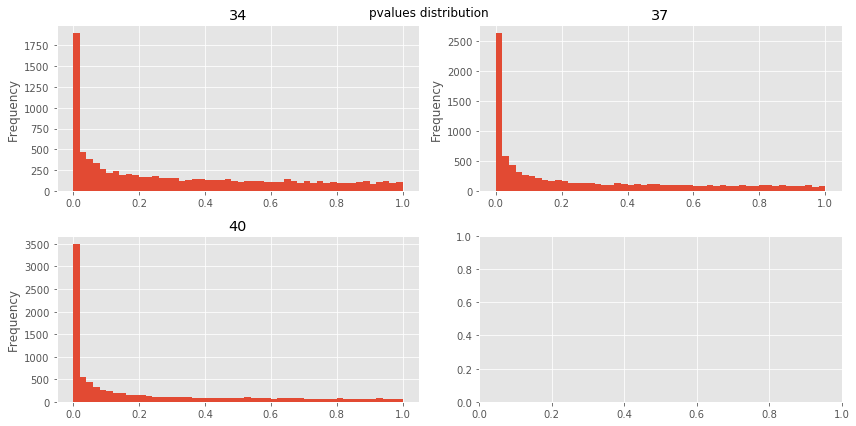

In [122]:
fig,axes=plt.subplots(ncols=2,nrows=2,figsize=(12,6))
axes=axes.flatten()
for i, key in enumerate(table_dict.keys()):
    
    table_dict[key].PValue.plot(kind='hist',bins=50,ax=axes[i])
    axes[i].set_title(key)
    #plt.suptitle('pval distributions',y=1.05,fontsize=24)
plt.suptitle('pvalues distribution')
plt.tight_layout()
plt.savefig('Figures_927/pval_dist.png')
plt.show()

In [123]:
#table_DRBD17.sort_values('logCPM').tail(5)

In [124]:
table1.head()

,logFC,logCPM,F,PValue,FDR,mlog10FDR,mlog10pvalue,desc,start,chro,domain,sense,sense_number
Tb05.5K5.10,-0.046733,-0.844108,0.021088,0.885625,0.947544,0.023401,0.052750,conserved hypothetical protein conserved (fra...,3,5K5_v5.1,Nudix_Hydrolase superfamily,-,-1
Tb05.5K5.20,-0.071992,4.711672,2.029482,0.165799,0.383517,0.416216,0.780419,hypothetical protein conserved,150,5K5_v5.1,TrmB superfamily,-,-1
Tb05.5K5.30,0.116190,4.957458,1.137752,0.295630,0.533770,0.272646,0.529252,BAC from homologous region on chr5 serine/thr...,3300,5K5_v5.1,MPP_PPP_family; Plus-3 superfamily,-,-1
Tb05.5K5.40,0.056228,6.129805,1.095123,0.304673,0.543311,0.264951,0.516166,hypothetical protein conserved,8406,5K5_v5.1,,-,-1
Tb05.5K5.50,-0.075742,4.801113,1.692933,0.204275,0.431707,0.364811,0.689784,hypothetical protein conserved,9142,5K5_v5.1,LRR_RI superfamily,-,-1


In [125]:
#lncRNA
#df_BES
#df_vsgs
#vsg

#Tb427VSG

In [126]:
vsg = [n for n in table1.index.values if 'Tb427VSG-' in n]
len(vsg)

40

In [127]:
'''
vsg
for n in vsg:
    desc = desc_dict[n].replace('gene_','')
    if '_BES' not in desc:
        if '_MES' not in desc:
            if '_array_' not in desc:
                if '_MC' not in desc:
                    print('>'+n.replace('gene_','')+' '+'MC\n')
'''

"\nvsg\nfor n in vsg:\n    desc = desc_dict[n].replace('gene_','')\n    if '_BES' not in desc:\n        if '_MES' not in desc:\n            if '_array_' not in desc:\n                if '_MC' not in desc:\n                    print('>'+n.replace('gene_','')+' '+'MC\n')\n"

In [128]:
#df_BES

In [129]:
ESAG = list(df_bes.index.values)
ESAG = [n for n in ESAG if n in table1.index.values]
len(ESAG)

136

In [130]:
lncRNA = table1[table1['desc'].str.contains('KS17gene_')].index.values

In [131]:
len(lncRNA)

0

In [132]:
for table,name in zip(table_dict.values(),table_dict.keys()):
    print(name,table['logFC'].max(),table['logFC'].min())

34 16.583861118423645 -9.042079516222332
37 16.682170537099083 -8.556199273068895
40 12.80689599498355 -9.06109429261846


In [133]:
#vsg

In [134]:
set_bes = []
set_mes = []
set_array = []
set_mc = []
for n in vsg:
    desc = desc_dict[n]
    if n in out_table.index.values:
        #print(n, desc)
        if  '_BES' in desc:
            set_bes.append(n)
        if '_MES'  in desc:
            set_mes.append(n)
        if '_array'  in desc:
            set_array.append(n)     
        if '_MC'  in desc:
            set_mc.append(n)
len(set_bes),len(set_mes),len(set_array),len(set_mc)

(12, 5, 18, 5)

In [135]:
bes1 = list(table1[table1['chro']=='FM162566.1'].index.values)
bes1.append('gene_Tb427VSG-2')
bes1

['gene_Tb427VSG-2']

In [136]:
#bes1 = table_DRBD17[table_DRBD17['chro'].str.startswith('BES1_')].index.values

skip = ['gene-Tb427.BES129.1','gene-Tb427.BES40.1','gene-Tb427.BES10.0']
table1.loc[skip][['logFC','desc']]

,logFC,desc
gene-Tb427.BES129.1,16.583861,gene-Tb427.BES129.1
gene-Tb427.BES40.1,13.248825,gene-Tb427.BES40.1
gene-Tb427.BES10.0,6.893775,gene-Tb427.BES10.0


In [137]:
table.loc['Tb927.10.10850']

logFC                      -9.06109
logCPM                      5.51673
F                           13465.4
PValue                  8.61863e-38
FDR                     8.09806e-34
mlog10FDR                   33.0916
mlog10pvalue                37.0646
desc            Protein argonaute-1
start                       2634905
chro                  Tb927_10_v5.1
domain                    Piwi; PAZ
sense                             -
sense_number                     -1
Name: Tb927.10.10850, dtype: object

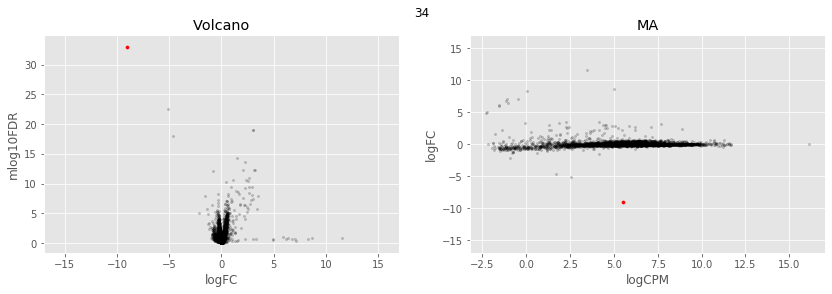

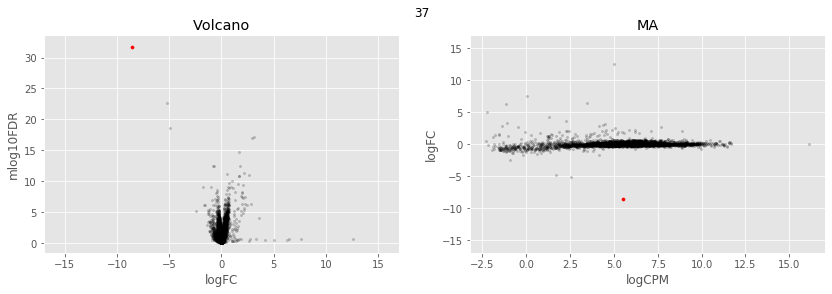

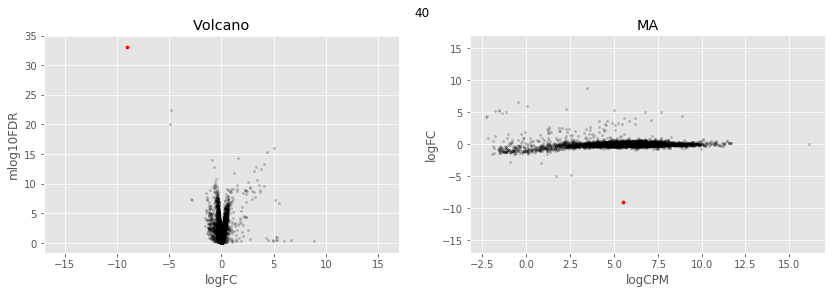

In [138]:
for table,name in zip(table_dict.values(),table_dict.keys()):
    
    
    table = table[~table.index.str.contains('_MARKER')]
    table = table[~table.index.isin(skip)]
    fig,axes=plt.subplots(figsize=(14,4), ncols=2, nrows=1)
    ax=axes[0]
    table.plot(x='logFC',y='mlog10FDR',
           kind='scatter',s=5,alpha=0.2,ax=ax,c='black')
    table.loc[['Tb927.10.10850']].plot(x='logFC',y='mlog10FDR',
           kind='scatter',s=10,alpha=1,ax=ax,c='red')
    ax.set_xlim(-17,17)
    ax.set_title('Volcano')
    
    ax=axes[1]
    table.plot(x='logCPM',y='logFC',
           kind='scatter',s=5,alpha=0.2,ax=ax,c='black')
    
    table.loc[['Tb927.10.10850']].plot(x='logCPM',y='logFC',
           kind='scatter',s=10,alpha=1,ax=ax,c='red')
    ax.set_ylim(-17,17)
    ax.set_title('MA')
    plt.suptitle(name)
    plt.savefig(f'Figures_927/Figure_{name}_highlight_AGO1.png')
    plt.show()

In [139]:
len(set_bes),len(set_mes),len(set_array),len(set_mc)

(12, 5, 18, 5)

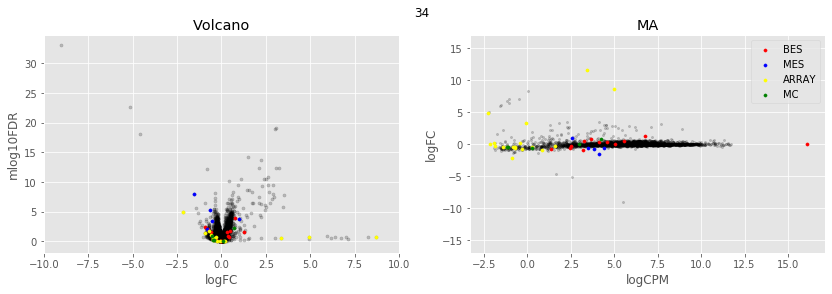

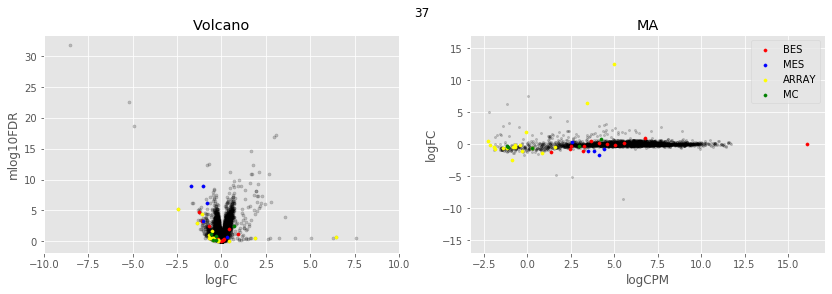

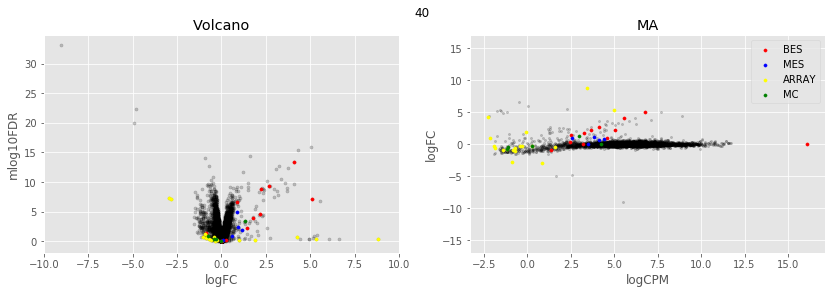

In [140]:
for table,name in zip(table_dict.values(),table_dict.keys()):
    fig,axes=plt.subplots(figsize=(14,4), ncols=2, nrows=1)
    ax=axes[0]
    
    table = table[~table.index.str.contains('_MARKER')]
    table = table[~table.index.isin(skip)]
    table.plot(x='logFC',y='mlog10FDR',
           kind='scatter',s=10,alpha=0.2,ax=ax,c='black')
    table.loc[set_bes].plot(x='logFC',y='mlog10FDR',
           kind='scatter',s=10,alpha=1,ax=ax,c='red')
    table.loc[set_mes].plot(x='logFC',y='mlog10FDR',
           kind='scatter',s=10,alpha=1,ax=ax,c='blue')  
    table.loc[set_array].plot(x='logFC',y='mlog10FDR',
           kind='scatter',s=10,alpha=1,ax=ax,c='yellow')  
    table.loc[set_mc].plot(x='logFC',y='mlog10FDR',
           kind='scatter',s=10,alpha=1,ax=ax,c='green')      
    ax.set_xlim(-10,10)
    ax.set_title('Volcano')
    
    ax=axes[1]
    table.plot(x='logCPM',y='logFC',
           kind='scatter',s=5,alpha=0.2,ax=ax,c='black')
    
    table.loc[set_bes].plot(x='logCPM',y='logFC',
           kind='scatter',s=10,alpha=1,ax=ax,c='red', label = 'BES')
    table.loc[set_mes].plot(x='logCPM',y='logFC',
           kind='scatter',s=10,alpha=1,ax=ax,c='blue', label = 'MES')  
    table.loc[set_array].plot(x='logCPM',y='logFC',
           kind='scatter',s=10,alpha=1,ax=ax,c='yellow', label = 'ARRAY') 
    table.loc[set_mc].plot(x='logCPM',y='logFC',
           kind='scatter',s=10,alpha=1,ax=ax,c='green', label = 'MC')     
    
    ax.set_ylim(-17,17)
    ax.set_title('MA')
    plt.legend()
    plt.suptitle(name)
    plt.savefig(f'Figures_927/Figure_{name}_highlight_VSG.png')
    plt.show()

In [141]:
#table.sort_values('logFC')

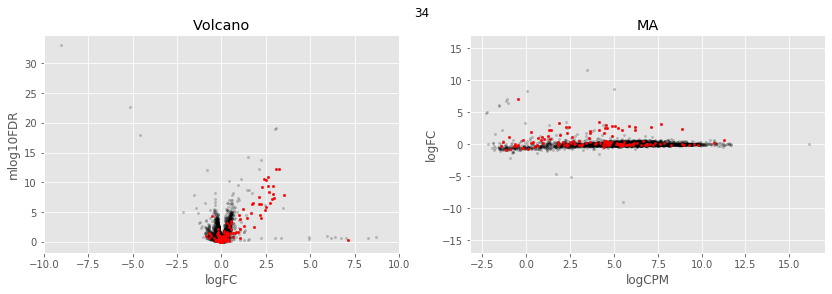

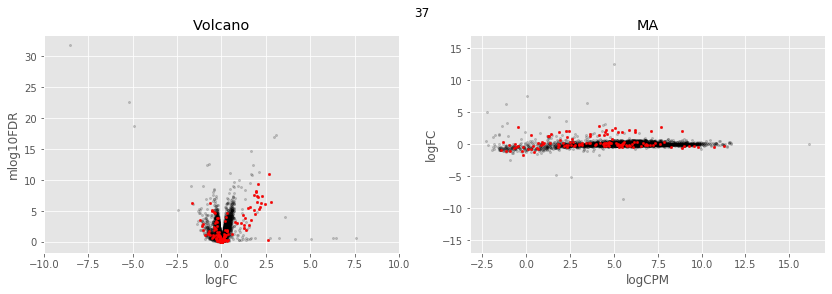

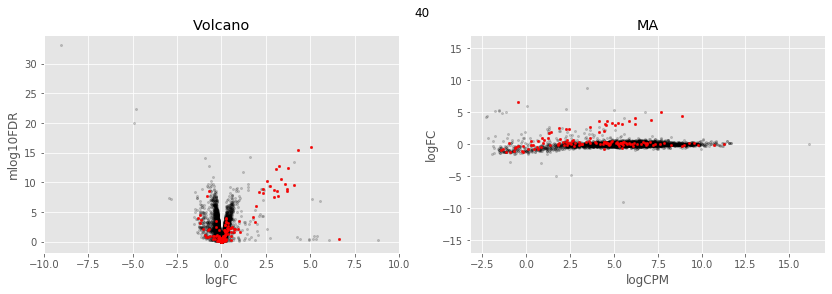

In [142]:
for table,name in zip(table_dict.values(),table_dict.keys()):
    
    table = table[~table.index.str.contains('_MARKER')]
    table = table[~table.index.isin(skip)]

    fig,axes=plt.subplots(figsize=(14,4), ncols=2, nrows=1)
    ax=axes[0]
    table.plot(x='logFC',y='mlog10FDR',
           kind='scatter',s=5,alpha=0.2,ax=ax,c='black')
    table.loc[ESAG].plot(x='logFC',y='mlog10FDR',
           kind='scatter',s=5,alpha=1,ax=ax,c='red')
    ax.set_xlim(-10,10)
    ax.set_title('Volcano')
    ax=axes[1]
    table.plot(x='logCPM',y='logFC',
           kind='scatter',s=5,alpha=0.2,ax=ax,c='black')
    
    table.loc[ESAG].plot(x='logCPM',y='logFC',
           kind='scatter',s=5,alpha=1,ax=ax,c='red')
    ax.set_ylim(-17,17)
    ax.set_title('MA')
    plt.suptitle(name)
    plt.savefig(f'Figures_927/Figure_{name}_highlight_ESAG.png')
    plt.show() 

In [143]:
'''
for table,name in zip(table_dict.values(),table_dict.keys()):
    
    table = table[~table.index.str.contains('_MARKER')]
    table = table[~table.index.isin(skip)]
    fig,axes=plt.subplots(figsize=(14,4), ncols=2, nrows=1)
    ax=axes[0]
    table.plot(x='logFC',y='mlog10FDR',
           kind='scatter',s=5,alpha=0.2,ax=ax,c='black')
    table.loc[lncRNA].plot(x='logFC',y='mlog10FDR',
           kind='scatter',s=5,alpha=1,ax=ax,c='red')
    ax.set_xlim(-10,10)
    ax.set_title('Volcano')
    ax=axes[1]
    table.plot(x='logCPM',y='logFC',
           kind='scatter',s=5,alpha=0.2,ax=ax,c='black')
    
    table.loc[lncRNA].plot(x='logCPM',y='logFC',
           kind='scatter',s=5,alpha=1,ax=ax,c='red')
    ax.set_ylim(-10,10)
    ax.set_title('MA')
    plt.suptitle(name)
    plt.savefig(f'Figures_927/Figure_{name}_highlight_lncRNA.png')
    plt.show()
'''

"\nfor table,name in zip(table_dict.values(),table_dict.keys()):\n    \n    table = table[~table.index.str.contains('_MARKER')]\n    table = table[~table.index.isin(skip)]\n    fig,axes=plt.subplots(figsize=(14,4), ncols=2, nrows=1)\n    ax=axes[0]\n    table.plot(x='logFC',y='mlog10FDR',\n           kind='scatter',s=5,alpha=0.2,ax=ax,c='black')\n    table.loc[lncRNA].plot(x='logFC',y='mlog10FDR',\n           kind='scatter',s=5,alpha=1,ax=ax,c='red')\n    ax.set_xlim(-10,10)\n    ax.set_title('Volcano')\n    ax=axes[1]\n    table.plot(x='logCPM',y='logFC',\n           kind='scatter',s=5,alpha=0.2,ax=ax,c='black')\n    \n    table.loc[lncRNA].plot(x='logCPM',y='logFC',\n           kind='scatter',s=5,alpha=1,ax=ax,c='red')\n    ax.set_ylim(-10,10)\n    ax.set_title('MA')\n    plt.suptitle(name)\n    plt.savefig(f'Figures_927/Figure_{name}_highlight_lncRNA.png')\n    plt.show()\n"

In [144]:
indata

,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,WT.37.C,WT.40.A,WT.40.B,WT.40.C,ago1A.34.A,...,ago1A.40.C,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C
Tb05.5K5.10,12,9,6,13,9,13,7,15,10,14,...,18,11,9,15,13,12,11,20,16,8
Tb05.5K5.20,587,598,568,756,740,748,884,796,873,552,...,742,577,521,508,516,641,585,714,765,780
Tb05.5K5.30,637,772,617,799,711,789,975,948,936,834,...,957,806,581,749,610,968,879,582,897,818
Tb05.5K5.40,1810,1581,1735,1904,2104,1872,1918,1779,1843,1539,...,1759,1705,1842,1694,1629,1804,1745,2091,2007,1794
Tb05.5K5.50,746,719,709,807,743,745,750,806,829,644,...,710,703,666,571,581,717,718,755,721,701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-Tb427.BES51.7,133,134,89,120,105,138,227,217,223,110,...,235,188,153,122,143,134,182,284,296,329
gene-Tb427.BES51.8,1101,1052,934,960,831,942,813,1124,1030,1350,...,1109,1748,1709,1287,1227,1484,1595,1218,1447,1354
gene-Tb427.BES51.9,3171,3311,3305,3197,3206,3086,4394,4776,4691,3411,...,4471,3432,3424,3017,3282,3736,3571,4855,4819,4689
gene-Tb427.BES51.10,386,452,397,468,357,391,506,616,638,432,...,650,553,486,416,451,472,546,774,803,817


In [145]:
print('DONE')

DONE


In [146]:
for table,name in zip(table_dict.values(),table_dict.keys()):
    print(name)

34
37
40


In [147]:
table1.loc[set_bes]

,logFC,logCPM,F,PValue,FDR,mlog10FDR,mlog10pvalue,desc,start,chro,domain,sense,sense_number
gene_Tb427VSG-2,-3.375436e-08,16.119117,4.846194e-08,0.999826,0.999826,0.000076,0.000076,gene_Tb427VSG-2_BES,1,Tb427VSG-2,,+,1
gene_Tb427VSG-11,-5.450339e-02,5.047770,7.659460e-02,0.784087,0.892355,0.049462,0.105636,gene_Tb427VSG-11_BES,1,Tb427VSG-11,,+,1
gene_Tb427VSG-3,-9.289905e-01,3.227639,1.889636e+01,0.000178,0.003394,2.469309,3.750287,gene_Tb427VSG-3_BES,1,Tb427VSG-3,,+,1
gene_Tb427VSG-6,4.952524e-01,5.564459,1.175759e+01,0.001971,0.020352,1.691393,2.705294,gene_Tb427VSG-6_BES,1,Tb427VSG-6,,+,1
gene_Tb427VSG-8,1.269323e+00,6.779089,1.086352e+01,0.002762,0.025546,1.592680,2.558729,gene_Tb427VSG-8_BES,1,Tb427VSG-8,,+,1
gene_Tb427VSG-9,-3.287196e-01,2.511650,1.082445e+00,0.307434,0.546059,0.262761,0.512248,gene_Tb427VSG-9_BES,1,Tb427VSG-9,,+,1
gene_Tb427VSG-17,3.488052e-01,4.137936,5.381698e+00,0.028201,0.126842,0.896736,1.549740,gene_Tb427VSG-17_BES,1,Tb427VSG-17,,+,1
gene_Tb427VSG-13,-5.795183e-01,2.433089,1.075529e+01,0.002879,0.026295,1.580133,2.540701,gene_Tb427VSG-13_BES,1,Tb427VSG-13,,+,1
gene_Tb427VSG-18,7.354637e-01,3.640129,3.611326e+01,0.000002,0.000109,3.961930,5.674802,gene_Tb427VSG-18_BES,1,Tb427VSG-18,,+,1
gene_Tb427VSG-21,-7.528570e-01,1.369019,1.488046e+01,0.000650,0.009245,2.034071,3.187419,gene_Tb427VSG-21_BES,1,Tb427VSG-21,,+,1


In [148]:
table1[table1['chro']=='FM162580.1']

,logFC,logCPM,F,PValue,FDR,mlog10FDR,mlog10pvalue,desc,start,chro,domain,sense,sense_number


In [149]:
from adjustText import adjust_text
from matplotlib.ticker import FuncFormatter

def format_func(value, tick_number):
    return f'{value/1e6:.1f}M'
def make_plot_bes(table,table_name):
    core_chr = ['FM162566.1', 'FM162567.1', 'FM162569.1', 
                'FM162571.1', 'FM162572.1', 'FM162573.1', 
                'FM162575.1', 'FM162576.1', 'FM162577.1', 
                'FM162578.1', 'FM162579.1', 'FM162580.1', 
                'FM162581.1', 'FM162582.1']
    fig, axes = plt.subplots(figsize=(16, 12), ncols=3, nrows=5)
    axes=axes.flatten()
    for index, n in enumerate(core_chr):
        temp_ax = axes[index]
        #print(table[table['chro']==n])
        tmp = table[table['chro']==n]
        tmp['start']=tmp['start'].astype(int)
        tmp['logFC']=tmp['logFC'].astype(float)
        tmp.plot(kind='scatter',x='start',y='logFC',ax=temp_ax, s=5)
        tmp_select = tmp[( (tmp['logFC']>2) | (tmp['logFC']<-2)) & (tmp['logCPM']>1) ]
        if tmp_select.shape[0] > 0:
            tmp_select.plot(kind='scatter',x='start',y='logFC',ax=temp_ax,c='r')

        temp_ax.set_ylim(-10, 10)
        temp_ax.set_title(n)
        temp_ax.set_xlabel('')
        temp_ax.set_ylabel('')
        if index in [0,4,8]:
            temp_ax.set_ylabel('log2FC')        
        if index in [8,9]:
            temp_ax.set_xlabel('chromosome length')
            
        temp_ax.xaxis.set_major_formatter(FuncFormatter(format_func))
    #axes[-1].off()
    plt.suptitle(table_name,y=1.02,fontsize=18)
    plt.tight_layout()
    fig.delaxes(axes[-1])
    plt.savefig(f'Figures_927/Figure_{table_name}_BES_927.png')
    
    plt.show()       



In [150]:
#for table,name in zip(table_dict.values(),table_dict.keys()):
#    make_plot_bes(table,name)

In [151]:
table1.loc[ESAG].sort_values('logFC').head(10)

,logFC,logCPM,F,PValue,FDR,mlog10FDR,mlog10pvalue,desc,start,chro,domain,sense,sense_number
gene-Tb427.BES98.7,-0.893059,-1.128830,14.266279,2.148418e-02,0.104920,0.979143,1.667881,gene-Tb427.BES98.7,none,none,,none,-1
gene-Tb427.BES15.7,-0.723011,0.119622,10.095419,3.720578e-03,0.031551,1.500986,2.429390,gene-Tb427.BES15.7,none,none,,none,-1
gene-Tb427.BES129.9,-0.699862,-0.934421,8.489960,5.983766e-02,0.204449,0.689415,1.223025,gene-Tb427.BES129.9,none,none,,none,-1
gene-Tb427.BES98.9,-0.675261,-0.190667,10.190480,5.319669e-03,0.040619,1.391266,2.274115,gene-Tb427.BES98.9,none,none,,none,-1
gene-Tb427.BES65.12,-0.587322,-0.239316,5.468485,2.706502e-02,0.123269,0.909148,1.567592,gene-Tb427.BES65.12,none,none,,none,-1
gene-Tb427.BES122.10,-0.509463,4.412198,40.583848,8.242065e-07,0.000053,4.278338,6.083964,gene-Tb427.BES122.10,none,none,,none,-1
gene-Tb427.BES10.8,-0.435297,0.461542,3.378270,7.715567e-02,0.238072,0.623292,1.112632,gene-Tb427.BES10.8,none,none,,none,-1
gene-Tb427.BES129.5,-0.359454,-0.682722,2.706512,2.675991e-01,0.506322,0.295573,0.572515,gene-Tb427.BES129.5,none,none,,none,-1
gene-Tb427.BES126.8,-0.308263,-0.565373,0.909388,4.071338e-01,0.638103,0.195109,0.390263,gene-Tb427.BES126.8,none,none,,none,-1
gene-Tb427.BES40.15,-0.280697,2.304436,1.775183,1.939456e-01,0.419382,0.377390,0.712320,gene-Tb427.BES40.15,none,none,,none,-1


In [152]:
#indata.loc['gene-Tb427.BES126.13']

In [153]:
out_table.head()

,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,WT.37.C,WT.40.A,WT.40.B,WT.40.C,ago1A.34.A,...,ago1A.40.C,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C
Tb05.5K5.10,4.044135,3.289589,3.441043,4.048076,3.623082,3.913520,2.629976,3.570592,3.070837,3.863888,...,3.435164,3.495575,3.391075,3.994059,3.733666,3.548132,3.283070,3.868461,3.324671,2.123886
Tb05.5K5.20,5.607595,5.636729,5.633988,5.919362,5.913571,5.924424,5.862776,5.742673,5.840101,5.506581,...,5.681934,5.550605,5.535418,5.540896,5.514063,5.568486,5.491240,5.772552,5.717006,5.755916
Tb05.5K5.30,5.279778,5.529283,5.304946,5.515538,5.386165,5.518215,5.571489,5.613951,5.531745,5.636127,...,5.644432,5.636729,5.336239,5.671538,5.348065,5.696849,5.639643,5.189857,5.580585,5.487351
Tb05.5K5.40,7.326935,7.258184,7.336305,7.434766,7.542868,7.438076,7.319204,7.199229,7.246949,7.301725,...,7.310221,7.413589,7.433001,7.476566,7.448193,7.454857,7.405303,7.471204,7.474317,7.308386
Tb05.5K5.50,5.697899,5.667760,5.704295,5.755916,5.650685,5.664055,5.418219,5.590803,5.589669,5.536147,...,5.437610,5.664618,5.676199,5.489943,5.488002,5.523889,5.583688,5.678811,5.499963,5.469899


In [154]:
import os
import pandas as pd
all_changing = []
for table in ['WT40_vs_WT37.txt','WT40_vs_WT34.txt','WT34_vs_WT40.txt']:
    #if (table != 'indata.txt') and (table.count('WT') ==1 ) :
        print(table)
        table = pd.read_csv('contrast_tables_927/'+table,index_col=[0],sep='\t')
        table = table[ ( (table['logFC']<-1) | (table['logFC']>1) ) & (table['FDR'] < 0.01)]
        all_changing += list(table.index.values)
all_changing=set(all_changing)
all_changing=list(all_changing)
len(all_changing)

WT40_vs_WT37.txt
WT40_vs_WT34.txt
WT34_vs_WT40.txt


125

In [155]:
all_changing = [n for n in all_changing if n not in list(markers.index.values)]
len(all_changing)

125

In [156]:
skip = ['gene-Tb427.BES129.1','gene-Tb427.BES40.1','gene-Tb427.BES10.0']
all_changing = [n for n in all_changing if n not in list(skip)]
len(all_changing)

125

In [157]:
out_table = pd.read_csv('rpkm_927.csv',index_col=[0])
all_changing_df = out_table.loc[all_changing]
all_changing_df = all_changing_df[[n for n in all_changing_df.columns if 'WT' in n]]
all_changing_df.to_csv('indata_cluster_WT.csv')

In [158]:
import pandas as pd
import seaborn as sns
all_changing_df = pd.read_csv('indata_cluster_WT.csv',index_col=[0])

In [159]:
#normalized_df = #all_changing_df.copy() #all_changing_df.div(all_changing_df.max(axis=1), axis=0)
normalized_df = all_changing_df.div(all_changing_df.max(axis=1), axis=0)
normalized_df.head()

,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,WT.37.C,WT.40.A,WT.40.B,WT.40.C
Tb927.11.2650,0.899209,0.900658,0.892985,0.909326,0.902413,0.910250,0.994608,0.997572,1.000000
gene_Tb427VSG-397,0.881791,0.975634,0.948739,0.985713,0.932637,1.000000,0.323119,0.314782,0.344659
Tb927.10.6070,0.994685,1.000000,0.982589,0.963330,0.950686,0.979830,0.859527,0.836023,0.838197
Tb927.11.16130,0.956465,1.000000,0.972380,0.972380,0.976592,0.990504,0.868432,0.860238,0.868432
Tb927.7.1320,0.856666,0.847646,0.852861,0.861247,0.859264,0.852237,1.000000,1.000000,0.996198


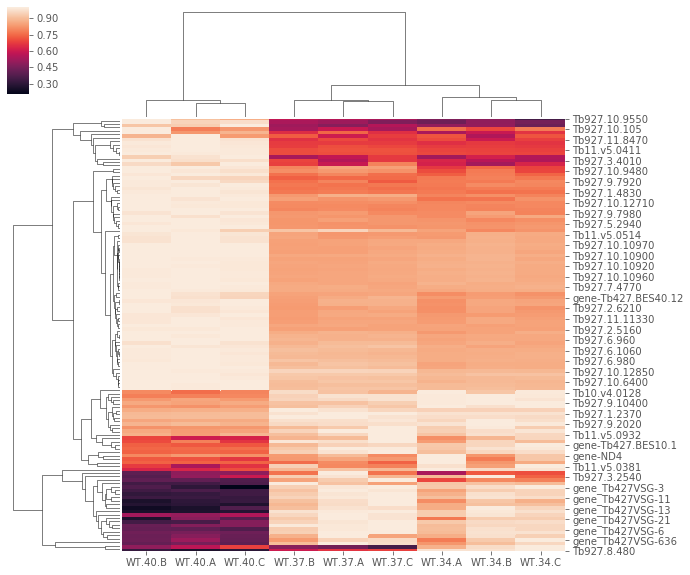

In [160]:
c = sns.clustermap(normalized_df)
c.savefig("Figures_927/clustermap_output_wt.png")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


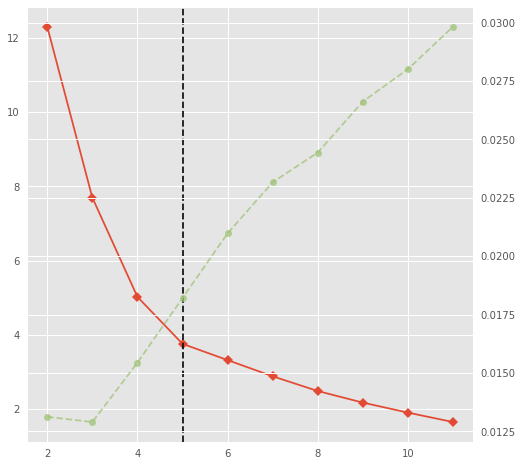

In [161]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
plt.style.use('ggplot')
X = normalized_df.copy()
# Instantiate the clustering model and visualizer
model = KMeans(random_state=2018)
fig, ax = plt.subplots(figsize=(8,8)) 
visualizer = KElbowVisualizer(model, k=(2,12), ax=ax)
#fig,ax= plt.subplots(figsize=(8,8))
visualizer.fit(X.values)
plt.savefig("Figures_927/elbow_plot_wt.png")        # Fit the data to the visualizer

In [162]:
kmeans = KMeans(n_clusters=5, random_state=2018).fit(X)
len(kmeans.labels_)

125

In [163]:
X['clusters']=kmeans.labels_

In [164]:
X.head()

,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,WT.37.C,WT.40.A,WT.40.B,WT.40.C,clusters
Tb927.11.2650,0.899209,0.900658,0.892985,0.909326,0.902413,0.910250,0.994608,0.997572,1.000000,1
gene_Tb427VSG-397,0.881791,0.975634,0.948739,0.985713,0.932637,1.000000,0.323119,0.314782,0.344659,3
Tb927.10.6070,0.994685,1.000000,0.982589,0.963330,0.950686,0.979830,0.859527,0.836023,0.838197,0
Tb927.11.16130,0.956465,1.000000,0.972380,0.972380,0.976592,0.990504,0.868432,0.860238,0.868432,0
Tb927.7.1320,0.856666,0.847646,0.852861,0.861247,0.859264,0.852237,1.000000,1.000000,0.996198,1


Cluster: 0


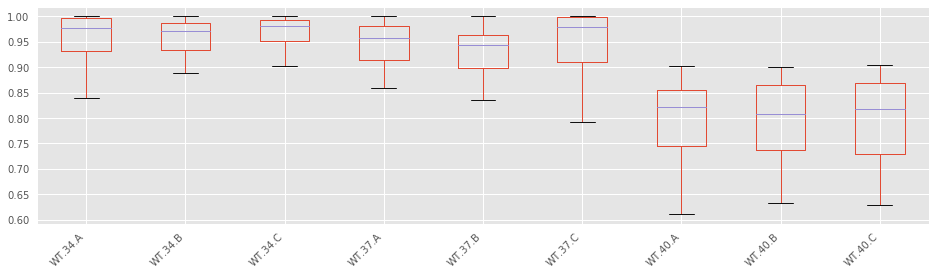

Cluster: 1


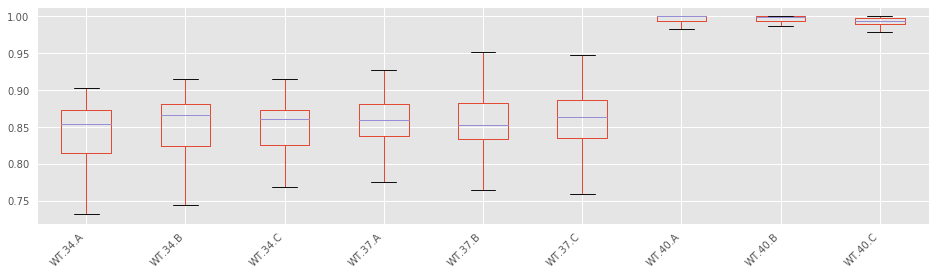

Cluster: 2


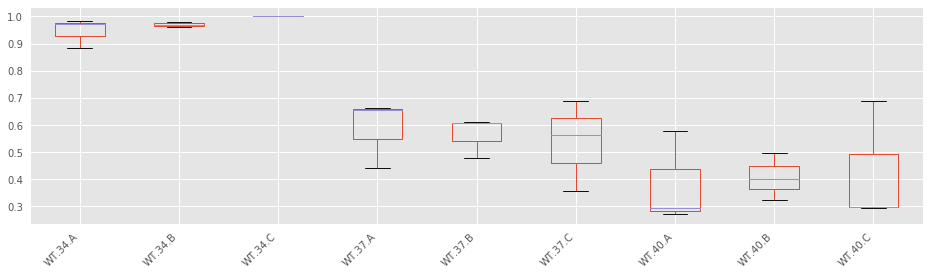

Cluster: 3


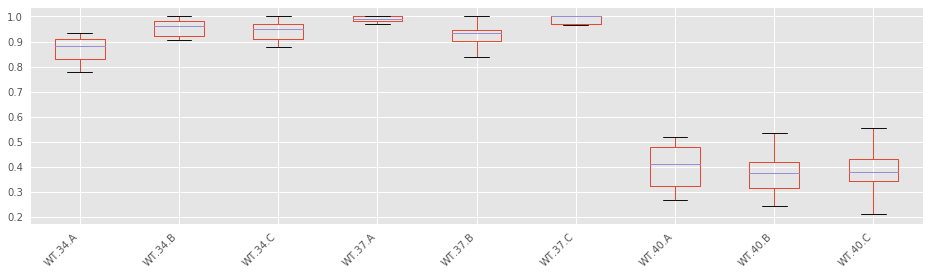

Cluster: 4


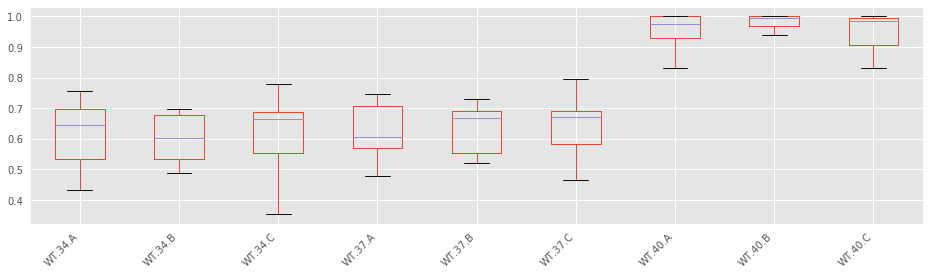

In [165]:
plt.style.use('ggplot')
for n in range(5):
    print('Cluster:',n)
    temp = X[X['clusters']==n].iloc[:,0:-1]
    temp.plot(kind='box',showfliers=False,figsize=(16,4))
    #plt.ylim(-1, 1.5)
    plt.xticks(rotation=45, ha='right')
    plt.savefig(f'Figures_927/cluster_wt_{n}.png')
    plt.show()

In [166]:
X.to_csv('indata_cluster_WT_with_labels.csv')

In [188]:
import os
all_changing = []
for table in ['WT40_vs_MUT40.txt','WT37_vs_MUT37.txt','WT34_vs_MUT34.txt']:
    #if (table != 'indata.txt') and (table.count('WT') ==1 ) :
        print(table)
        table = pd.read_csv('contrast_tables_927/'+table,index_col=[0],sep='\t')
        table = table[ ( (table['logFC']<-1) | (table['logFC']>1) ) & (table['FDR'] < 0.01)]
        all_changing += list(table.index.values)
all_changing=set(all_changing)
all_changing=list(all_changing)
len(all_changing)

WT40_vs_MUT40.txt
WT37_vs_MUT37.txt
WT34_vs_MUT34.txt


171

In [189]:
all_changing = [n for n in all_changing if n not in list(markers.index.values)]
len(all_changing)

167

In [190]:
#skip

In [191]:
all_changing = [n for n in all_changing if n not in list(skip)]
len(all_changing)

164

In [192]:
all_changing_df = out_table.loc[all_changing]

In [193]:
all_changing_df.to_csv('indata_cluster.csv')

In [2]:
import pandas as pd
import seaborn as sns
all_changing_df = pd.read_csv('indata_cluster.csv',index_col=[0])

In [3]:
#normalized_df.columns

#normalized_df['']

In [4]:
#normalized_df = #all_changing_df.copy() #all_changing_df.div(all_changing_df.max(axis=1), axis=0)
normalized_df = all_changing_df.div(all_changing_df.max(axis=1), axis=0)
normalized_df.head()

,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,WT.37.C,WT.40.A,WT.40.B,WT.40.C,ago1A.34.A,...,ago1A.40.C,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C
Tb927.11.8840,0.819919,0.886023,0.743247,0.743247,0.743247,0.915696,0.974209,0.886023,1.000000,0.352634,...,0.162013,0.491218,0.352634,0.352634,0.743247,0.701300,0.491218,0.162013,0.255126,0.162013
Tb927.10.7150,0.706961,0.667062,0.743620,0.667062,0.706961,0.870990,1.000000,0.900143,0.951178,0.242670,...,-0.070445,-0.070445,0.154103,0.154103,0.335418,0.242670,0.154103,-0.070445,-0.070445,0.335418
Tb11.v5.0558,0.869261,0.881761,0.850457,0.835035,0.813671,0.822526,0.773343,0.797936,0.783286,0.993571,...,0.957926,0.975838,0.957044,0.958094,0.877666,0.878945,0.876446,0.917476,0.931283,0.947016
Tb08.27P2.240,1.000000,0.808400,0.735222,0.852784,0.759845,0.829801,0.453470,0.407613,0.504090,0.134438,...,-0.938904,-0.061456,0.134438,-0.061456,-0.061456,-0.061456,-0.061456,-0.352288,-0.352288,-0.555037
Tb927.7.6880,0.536339,0.564503,0.572671,0.466989,0.533755,0.473305,0.488395,0.513679,0.504237,0.669709,...,0.730949,0.834897,0.851354,0.834635,0.814535,0.782702,0.776261,0.990301,1.000000,0.962744


In [5]:
#out_table.loc[all_changing].divide(max_row.values,axis=1)

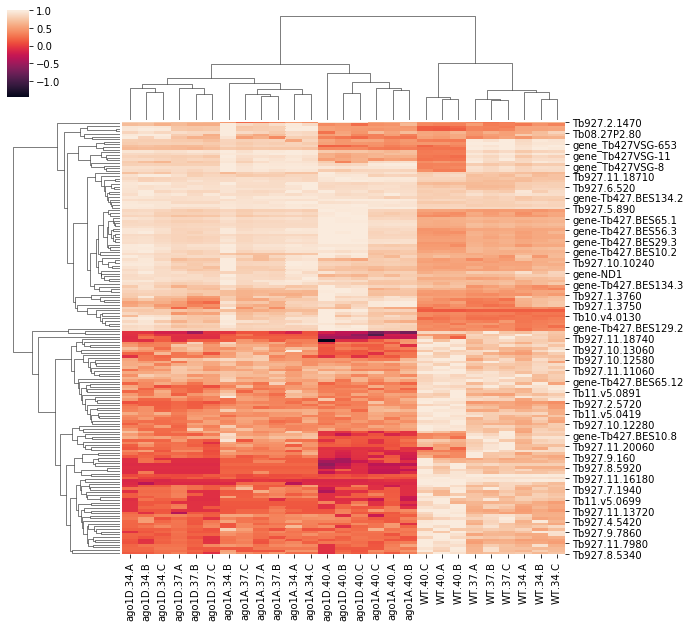

In [6]:
c = sns.clustermap(normalized_df)
c.savefig("Figures_927/clustermap_output.png")

In [7]:
#sns.clustermap(out_table.loc[all_changing],z_score=True)

In [8]:
'''
%%R -i normalized_df
library('NbClust')
nb <- NbClust(normalized_df, diss=NULL, distance = "euclidean",
        method = "kmeans", min.nc=2, max.nc=15, 
        index = "alllong", alphaBeale = 0.1)
hist(nb$Best.nc[1,], breaks = max(na.omit(nb$Best.nc[1,])))
'''

'\n%%R -i normalized_df\nlibrary(\'NbClust\')\nnb <- NbClust(normalized_df, diss=NULL, distance = "euclidean",\n        method = "kmeans", min.nc=2, max.nc=15, \n        index = "alllong", alphaBeale = 0.1)\nhist(nb$Best.nc[1,], breaks = max(na.omit(nb$Best.nc[1,])))\n'

In [37]:
#KElbowVisualizer??
#KMeans??
#visualizer??

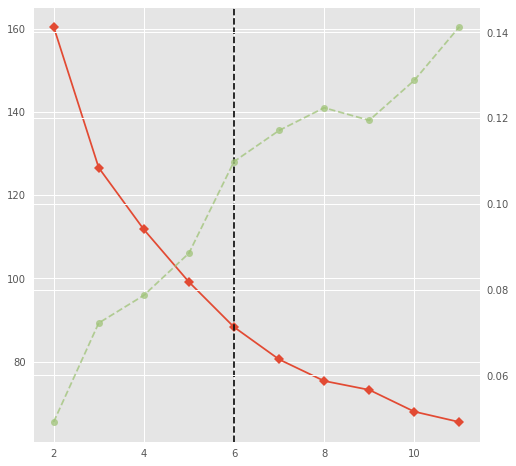

In [40]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
plt.style.use('ggplot')
X = normalized_df.copy()
# Instantiate the clustering model and visualizer
model = KMeans(random_state=2018)
fig, ax = plt.subplots(figsize=(8,8)) 
visualizer = KElbowVisualizer(model, k=(2,12), ax=ax)
#fig,ax= plt.subplots(figsize=(8,8))
visualizer.fit(X.values)
plt.savefig("Figures_927/elbow_plot.png")        # Fit the data to the visualizer

In [26]:
kmeans = KMeans(n_clusters=6, random_state=2018).fit(X)
len(kmeans.labels_)

164

In [27]:
X['clusters']=kmeans.labels_

In [28]:
X.head()

,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,WT.37.C,WT.40.A,WT.40.B,WT.40.C,ago1A.34.A,...,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C,clusters
Tb927.11.8840,0.819919,0.886023,0.743247,0.743247,0.743247,0.915696,0.974209,0.886023,1.000000,0.352634,...,0.491218,0.352634,0.352634,0.743247,0.701300,0.491218,0.162013,0.255126,0.162013,5
Tb927.10.7150,0.706961,0.667062,0.743620,0.667062,0.706961,0.870990,1.000000,0.900143,0.951178,0.242670,...,-0.070445,0.154103,0.154103,0.335418,0.242670,0.154103,-0.070445,-0.070445,0.335418,0
Tb11.v5.0558,0.869261,0.881761,0.850457,0.835035,0.813671,0.822526,0.773343,0.797936,0.783286,0.993571,...,0.975838,0.957044,0.958094,0.877666,0.878945,0.876446,0.917476,0.931283,0.947016,1
Tb08.27P2.240,1.000000,0.808400,0.735222,0.852784,0.759845,0.829801,0.453470,0.407613,0.504090,0.134438,...,-0.061456,0.134438,-0.061456,-0.061456,-0.061456,-0.061456,-0.352288,-0.352288,-0.555037,3
Tb927.7.6880,0.536339,0.564503,0.572671,0.466989,0.533755,0.473305,0.488395,0.513679,0.504237,0.669709,...,0.834897,0.851354,0.834635,0.814535,0.782702,0.776261,0.990301,1.000000,0.962744,4


Cluster: 0


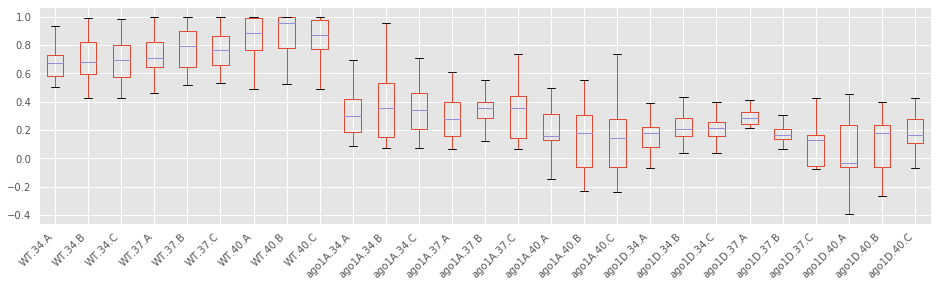

Cluster: 1


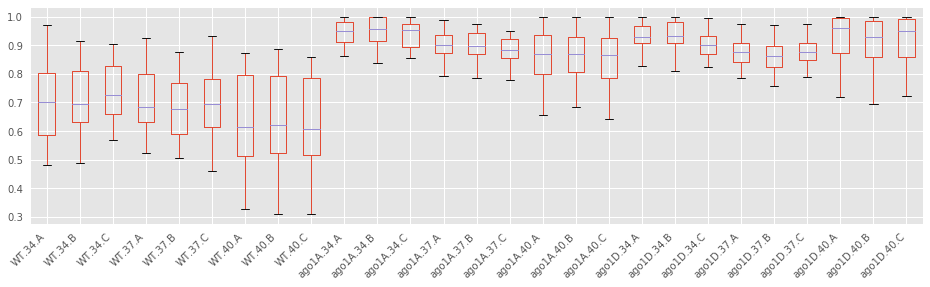

Cluster: 2


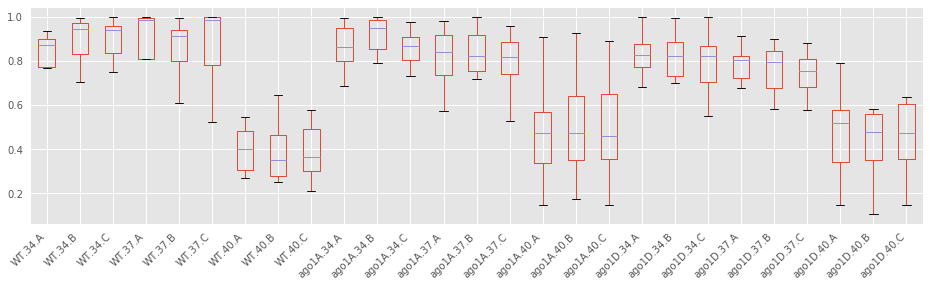

Cluster: 3


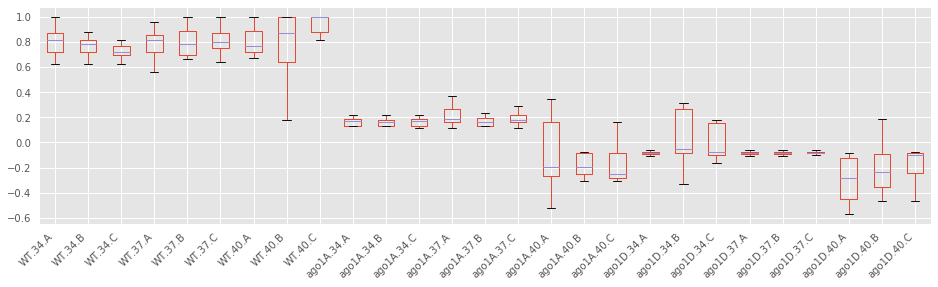

Cluster: 4


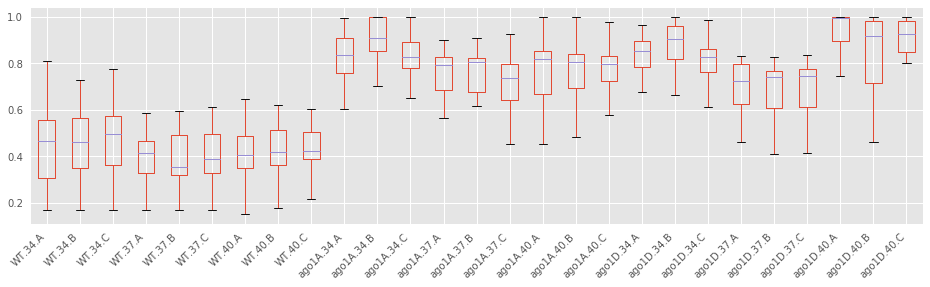

Cluster: 5


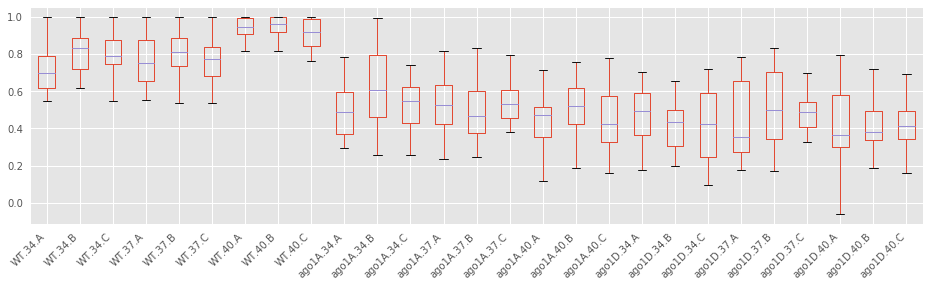

In [29]:
plt.style.use('ggplot')
for n in range(6):
    print('Cluster:',n)
    temp = X[X['clusters']==n].iloc[:,0:-1]
    temp.plot(kind='box',showfliers=False,figsize=(16,4))
    #plt.ylim(-1, 1.5)
    plt.xticks(rotation=45, ha='right')
    plt.savefig(f'Figures_927/cluster_{n}.png')
    plt.show()

In [30]:
X.to_csv('indata_cluster_with_labels.csv')

In [357]:
#indata.max()

## Prepare Web Tables

In [358]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
conditions = [    
    'WT34','WT34','WT34',
    'WT37','WT37','WT37',
    'WT40','WT40','WT40',
    'MUT34','MUT34','MUT34',
    'MUT37','MUT37','MUT37',
    'MUT40','MUT40','MUT40',
    'MUT34','MUT34','MUT34',
    'MUT37','MUT37','MUT37',
    'MUT40','MUT40','MUT40']
samples = indata.columns

sample_dictionary = {}

for c,s in zip(conditions,samples):
    if c in sample_dictionary:
        sample_dictionary[c].append(s)
    else:
        sample_dictionary[c] = [s]    
sample_dictionary 

{'WT34': ['WT.34.A', 'WT.34.B', 'WT.34.C'],
 'WT37': ['WT.37.A', 'WT.37.B', 'WT.37.C'],
 'WT40': ['WT.40.A', 'WT.40.B', 'WT.40.C'],
 'MUT34': ['ago1A.34.A',
  'ago1A.34.B',
  'ago1A.34.C',
  'ago1D.34.A',
  'ago1D.34.B',
  'ago1D.34.C'],
 'MUT37': ['ago1A.37.A',
  'ago1A.37.B',
  'ago1A.37.C',
  'ago1D.37.A',
  'ago1D.37.B',
  'ago1D.37.C'],
 'MUT40': ['ago1A.40.A',
  'ago1A.40.B',
  'ago1A.40.C',
  'ago1D.40.A',
  'ago1D.40.B',
  'ago1D.40.C']}

In [359]:
data_df = pd.read_csv('contrast_tables_927/indata.txt',sep='\t',index_col=[0])
data_df.head()   

,WT.34.A,WT.34.B,WT.34.C,WT.37.A,WT.37.B,WT.37.C,WT.40.A,WT.40.B,WT.40.C,ago1A.34.A,...,ago1D.34.A,ago1D.34.B,ago1D.34.C,ago1D.37.A,ago1D.37.B,ago1D.37.C,ago1D.40.A,ago1D.40.B,ago1D.40.C,desc
Tb05.5K5.10,12,9,6,13,9,13,7,15,10,14,...,11,9,15,13,12,11,20,16,8,conserved hypothetical protein conserved (fra...
Tb05.5K5.20,587,598,568,756,740,748,884,796,873,552,...,577,521,508,516,641,585,714,765,780,hypothetical protein conserved
Tb05.5K5.30,637,772,617,799,711,789,975,948,936,834,...,806,581,749,610,968,879,582,897,818,BAC from homologous region on chr5 serine/thr...
Tb05.5K5.40,1810,1581,1735,1904,2104,1872,1918,1779,1843,1539,...,1705,1842,1694,1629,1804,1745,2091,2007,1794,hypothetical protein conserved
Tb05.5K5.50,746,719,709,807,743,745,750,806,829,644,...,703,666,571,581,717,718,755,721,701,hypothetical protein conserved


In [360]:
!mkdir -p 'web_table_927'

In [361]:
def prepare_table_limma(data_df, condition_a,  condition_b, sample_dictionary):
    cols_a = sample_dictionary[condition_a]
    cols_b = sample_dictionary[condition_b]
    cols_a_new_names = [f'{condition_a}_{n}' for n in range(len(cols_a))]
    cols_b_new_names = [f'{condition_b}_{n}' for n in range(len(cols_b))]
    intensity_table = data_df[cols_a+cols_b+['desc']].copy()
    tmp_df = pd.read_csv(f'contrast_tables_927/{condition_a}_vs_{condition_b}.txt',sep='\t')
    merge_df= tmp_df.join(intensity_table)
    merge_df['Gene_acc']=range(merge_df.shape[0])
    merge_df['Gene_id']=merge_df.index.values
    merge_df['logFC']=merge_df['logFC']
    merge_df['log_AveExpr']=merge_df['logCPM']
    #merge_df['FDR']=merge_df['FDR']
    merge_df['FDR']=-np.log10(merge_df['FDR'])
    
    merge_df['Desc']=merge_df['desc']
    merge_df=merge_df[['Gene_acc','Gene_id','logFC','log_AveExpr','FDR','Desc']+cols_a+cols_b]
    merge_df=merge_df.rename(dict(zip(cols_a,cols_a_new_names)),axis=1)
    merge_df=merge_df.rename(dict(zip(cols_b,cols_b_new_names)),axis=1)
    merge_df=merge_df.reset_index(drop=True)
    
    #print(merge_df.head())
    merge_df.to_csv(f'web_table_927/for_web_{condition_a}_vs_{condition_b}.csv', index=False)

    

for a in tqdm(list(set(conditions))):
    for b in list(set(conditions)):
        if a == b:
            pass
        else:
            prepare_table_limma(data_df, a,  b, sample_dictionary)
            prepare_table_limma(data_df, b,  a, sample_dictionary)
            #cols_a = sample_dictionary[a]
            #cols_a_new_names = [f'{a}_{n}' for n in range(len(cols_a))]
            #cols_b = sample_dictionary[b]
            #cols_b_new_names = [f'{b}_{n}' for n in range(len(cols_b))]
            #intensity_table = data_df[cols_a+cols_b].copy()
            #tmp_df_1 = pd.read_csv(f'contrast_tables_927/{a}_vs_{b}.txt',sep='\t')
            #merge_df_1 = tmp_df_1.join(intensity_table)
            
            
            #tmp_df_2 = pd.read_csv(f'contrast_tables_927/{b}_vs_{a}.txt',sep='\t')
            #merge_df_2 = tmp_df_2.join(intensity_table)
            
            
            
            
    #break

In [214]:
#set(conditions)

## Compare Peter Count

In [ ]:
peter_counts = pd.read_csv('927_Mex67_counts.txt',sep='\t',index_col=[0])
peter_counts.head()

In [ ]:
pairs = [
    ('TbMex67_BSF','A1_BSF'),
     ('TbMex67_PCF','A1_PCF'),
    ('TbMex67B_BSF','B1_BSF'),
    ('TbMex67B_PCF','B1_PCF'),
    ('TbMex67L_BSF','L1_BSF'),
    ('TbMex67L_PCF','L1_PCF')]

In [ ]:
fig,axes=plt.subplots(ncols=3,nrows=2,figsize=(12,8))
axes=axes.flatten()
for i,pair in enumerate(pairs):
    np.log10(peter_counts).join(out_table,how='left').dropna().plot(kind='scatter',x=pair[0],y=pair[1],ax=axes[i])
plt.tight_layout()

In [ ]:
tmp =  np.log10(peter_counts).join(out_table,how='left').dropna()
tmp = tmp[ (tmp['TbMex67L_PCF']<0) & (tmp['L1_PCF']>10) ]

In [ ]:
#tmp.1.30
table_L_A_PCF.loc[tmp.index.values]

## Create interactive plots

In [ ]:
#import plotly.plotly as py
#from plotly.graph_objs import *

#!rm -r interactive_figures_927
!mkdir -p interactive_figures_927

import plotly.express as px
import plotly

def plot_html_ma(table, filename):
    temp = table.copy()
    temp['gene_ids']=temp.index.values

    fig = px.scatter(temp, x="logCPM", y="logFC", color="mlog10FDR", hover_name='desc',hover_data=['gene_ids'])
    plotly.offline.plot(fig, filename=filename)

    
def plot_html_volcano(table, filename):
    temp = table.copy()
    temp['gene_ids']=temp.index.values

    fig = px.scatter(temp, y="mlog10FDR", x="logFC", color="logCPM", hover_name='desc',hover_data=['gene_ids'])
    plotly.offline.plot(fig, filename=filename)

    
    
for table, name in zip(table_dict.values(),table_dict.keys()):
    
    plot_html_ma(table, 'interactive_figures_927/'+name+'_MA_10.html')
    plot_html_volcano(table, 'interactive_figures_927/'+name+'_VOLCANO_10.html')

In [ ]:
!mkdir -p save_tables_927
for table, name in zip(table_dict.values(),table_dict.keys()):

    table.to_csv('save_tables_927/'+name+'.csv')

In [ ]:
def annotated_volcano(table,name,selection=False):
    
    fig,axes=plt.subplots(figsize=(8,6), ncols=1, nrows=1)
    ax=axes
    if not selection:
        selection = table[((table['logFC']>2)|(table['logFC']<-2))
                          &(table['mlog10FDR']>6)&(table['logCPM']>6)]
    else:
        selection = table.loc[selection]
    annot_index = selection.index.values
    annot_names = selection['desc']
    annot_names = [n[0:12] for n in annot_names]
    UT.make_vulcano(
        table,
        ax,
        x='logFC',
        y='mlog10FDR',
        fc_col = 'logFC',
        pval_col = 'FDR',
        pval_limit=0.01,
        fc_limit=1,
        annot_index=annot_index ,
        annot_names=annot_names)
    ax.legend(loc='upper center', bbox_to_anchor=(0.8, 1.2), title='Legend')
    #ax.set_xlim(-3,3)
    plt.title(name)
    


In [ ]:
#tableCT2

In [ ]:
import plotly.express as px
import plotly


def plot_html_merge(table, filename):
    temp = table.copy()
    temp['gene_ids']=temp.index.values

    fig = px.scatter(temp, x="logFC", y="logFC_ty", color="mlog10FDR", hover_name='desc', hover_data=['gene_ids'])
    plotly.offline.plot(fig, filename=filename)


#plot_html_merge(merge_table, 'interactive_figures_927/C_vs_T_Merge.html')
#plot_html_volcano(table, 'interactive_figures_927/'+name+'__Merge.html')

In [ ]:
from adjustText import adjust_text

table_dict## Visualize core chromosomes

In [ ]:
table[table['chro']=='Tb927_01_v5.1']

In [ ]:
from matplotlib.ticker import FuncFormatter

def format_func(value, tick_number):
    return f'{value/1e6:.1f}M'

def make_plot_core(table,table_name):
    core_chr = [
        'Tb927_01_v5.1',
        'Tb927_02_v5.1',
        'Tb927_03_v5.1', 
        'Tb927_04_v5.1',
        'Tb927_05_v5.1', 
        'Tb927_06_v5.1',
        'Tb927_07_v5.1',
        'Tb927_08_v5.1',
      'Tb927_09_v5.1',
      'Tb927_10_v5.1',
      'Tb927_11_v5.1'
     ]
    fig, axes = plt.subplots(figsize=(16, 12), ncols=4, nrows=3)
    axes=axes.flatten()
    for index, n in enumerate(core_chr):
        temp_ax = axes[index]
        #print(table[table['chro']==n])
        tmp = table[table['chro']==n]
        tmp['start']=tmp['start'].astype(int)
        tmp['logFC']=tmp['logFC'].astype(float)
        tmp.plot(kind='scatter',x='start',y='logFC',ax=temp_ax, s=5)
        tmp_select = tmp[( (tmp['logFC']>2) | (tmp['logFC']<-2))]
        if tmp_select.shape[0] > 0:
            tmp_select.plot(kind='scatter',x='start',y='logFC',ax=temp_ax,c='r')

        temp_ax.set_ylim(-10, 10)
        temp_ax.set_title(n)
        temp_ax.set_xlabel('')
        temp_ax.set_ylabel('')
        if index in [0,4,8]:
            temp_ax.set_ylabel('log2FC')        
        if index in [8,9]:
            temp_ax.set_xlabel('chromosome length')
            
        temp_ax.xaxis.set_major_formatter(FuncFormatter(format_func))
    #axes[-1].off()
    plt.suptitle(table_name,y=1.02,fontsize=18)
    plt.tight_layout()
    fig.delaxes(axes[-1])
    plt.savefig(f'Figures_927/Figure_{table_name}_chromosomes.png')
    
    plt.show()
            
for table,name in zip(table_dict.values(),table_dict.keys()):
    make_plot_core(table,name)

In [ ]:
#table[table['chro']=='Tb927_02_v5.1'].sort_values('logFC')

In [ ]:
def make_plot_core(table,table_name):
    core_chr = [
        'Tb927_01_v5.1',
        'Tb927_02_v5.1',
        'Tb927_03_v5.1', 
        'Tb927_04_v5.1',
        'Tb927_05_v5.1', 
        'Tb927_06_v5.1',
        'Tb927_07_v5.1',
        'Tb927_08_v5.1',
      'Tb927_09_v5.1',
      'Tb927_10_v5.1',
      'Tb927_11_v5.1'
     ]
    fig, axes = plt.subplots(figsize=(16, 12), ncols=4, nrows=3)
    axes=axes.flatten()
    for index, n in enumerate(core_chr):
        temp_ax = axes[index]
        table[table['chro']==n].plot(kind='scatter',x='start',y='logFC',ax=temp_ax)
        table[(table['chro']==n) & ( (table['logFC']>1) | (table['logFC']<-1) )
                ].loc[lncRNA].plot(kind='scatter',x='start',y='logFC',ax=temp_ax,c='r')

        temp_ax.set_ylim(-10, 10)
        temp_ax.set_title(n)
        temp_ax.set_xlabel('')
        temp_ax.set_ylabel('')
        if index in [0,4,8]:
            temp_ax.set_ylabel('log2FC')        
        if index in [8,9]:
            temp_ax.set_xlabel('chromosome length')
    plt.suptitle(table_name)
    plt.tight_layout()
    plt.show()
            
for table,name in zip(table_dict.values(),table_dict.keys()):
    make_plot_core(table,name)

In [ ]:
def make_plot_ends(tableCT2):
    ends = [
     'Chr1_3A_Tb427v10',  
     'Chr1_3B_Tb427v10',     
     'Chr1_5A_Tb427v10',
     'Chr1_5B_Tb427v10',   

     'Chr3_3A_Tb427v10',    
     'Chr3_5B_Tb427v10',

     'Chr4_3A_Tb427v10',
     'Chr4_3B_Tb427v10',     
     'Chr4_5B_Tb427v10', 

     'Chr5_3A_Tb427v10',    
     'Chr5_3B_Tb427v10',    

     'Chr6_3A_Tb427v10',
     'Chr6_3B_Tb427v10',    

     'Chr10_3A_Tb427v10',    
     'Chr10_3B_Tb427v10',
     'Chr10_5A_Tb427v10', 
     'Chr10_5B_Tb427v10',    

     'Chr9_3B_Tb427v10',
     'Chr9_3A_Tb427v10',
     'Chr9_5A_Tb427v10',    
     'Chr9_5B_Tb427v10',

     'Chr7_5A_Tb427v10',


     'Chr8_3A_Tb427v10',
     'Chr8_5B_Tb427v10',
     'Chr8_5A_Tb427v10',    
     'Chr8_3B_Tb427v10',   

     'Chr11_3A_Tb427v10',
     'Chr11_3B_Tb427v10',
     'Chr11_5A_Tb427v10',    
     'Chr11_5B_Tb427v10',
    ]

    fig, axes = plt.subplots(figsize=(16,24),ncols=4,nrows=8)
    raw_index = 0
    col_index = 0
    for index, n in enumerate(ends):
        temp_ax = axes[raw_index, col_index]
        temp_df = tableCT2[tableCT2['chro']==n]
        if temp_df.shape[0]>0:
            temp_df.plot(kind='scatter',x='start',y='logFC',ax=temp_ax)

            temp_df = tableCT2[(tableCT2['chro']==n) & ( (tableCT2['logFC']>1) | (tableCT2['logFC']<-1))]
            if temp_df.shape[0]>0:
                temp_df.plot(kind='scatter',x='start',y='logFC',ax=temp_ax,c='r')

            col_index+=1
            if col_index>3:
                col_index=0
                raw_index+=1
            #temp_ax.set_ylim(-4.5,4.5)
            temp_ax.set_title(n)
            temp_ax.set_xlabel('')
            temp_ax.set_ylabel('')
            if raw_index == 2:
                temp_ax.set_xlabel('chromosome length')

            if col_index == 1:
                temp_ax.set_ylabel('log2FC')

    plt.tight_layout()
    

In [ ]:
def plot_chr(tableCT2,chro='Chr5_core_Tb427v10'):
    def assemble_polycistron(chro):
        sense_number = []
        start = []
        for g in list(chr_dict.keys()):
            if chr_dict[g] ==  chro:
                sense_number.append(sense_dict[g])
                start.append(start_dict[g])
        sense_number = [1 if n == '+' else -1 for n in sense_number]
        return start, sense_number


    #chro = 
    fig,ax=plt.subplots(figsize=(12,8))
    temp_t = tableCT2[tableCT2['chro']==chro]


    temp_t.plot(kind='scatter',x='start',y='logFC',ax=ax)
    #temp_t.plot(kind='line',x='start',y='sense_number',ax=ax,c='green')
    x,y=assemble_polycistron(chro)
    ax.scatter(x,y,marker='_')
    temp_t['rolling_1'] = temp_t['logFC'][::-1].rolling(window=15).mean()[::-1].values
    temp_t['rolling_2'] = temp_t['logFC'].rolling(window=15).mean().values
    temp_t['rolling'] = temp_t[['rolling_1','rolling_2']].mean(skipna=True,axis=1)
    #temp_t['rolling2'] = temp_t['logFC'].rolling(window=5).mean()
    temp_t.plot(kind='line',x='start',y='rolling',ax=ax)
    #ax.set_ylim(-4,4)
    ax.set_xlim(-4-(temp_t.start.max()*0.01),temp_t.start.max()+(temp_t.start.max()*0.01))
    plt.show()

    tableCT2[(tableCT2['chro']==chro) & (tableCT2['logFC']>1)]

In [ ]:
#make_plot_bes(table_E3KT_E3KC)


In [ ]:
#table_E3SD_P
#table_E3SD_E3KC
#table_E3SD_E3KT
#table_E3KT_E3KC
#table_E3KT_P

In [ ]:
#table_E3SD_P.head()

In [ ]:
!mkdir -p save_notebook

In [ ]:
!jupyter nbconvert --to html_toc --output-dir save_notebook FiguresPaper-927_55.ipynb

In [ ]:
!wget ftp://ftp.pride.ebi.ac.uk/pride/data/archive/2023/10/PXD039578/DIA-NN_output_Hela_SILAC_benchmark_DIA_strictpg.zip